In [27]:
import os
import sys
import math
import random
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('Agg')  # Non-interactive backend for HPC
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from glob import glob
import gc

In [28]:
def setup_logging(log_dir='logs', experiment_name='smr_seld'):
    """Setup comprehensive logging for HPC environment"""
    os.makedirs(log_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    log_file = os.path.join(log_dir, f'{experiment_name}_{timestamp}.log')
    
    # Create logger
    logger = logging.getLogger('SMR_SELD')
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to prevent duplicates when re-running cells
    if logger.handlers:
        logger.handlers.clear()
    
    # File handler
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.INFO)
    
    # Console handler
    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.INFO)
    
    # Formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    
    logger.addHandler(fh)
    logger.addHandler(ch)
    
    return logger, log_file

logger, log_file = setup_logging()

In [29]:
def get_device():
    """Get available device with CUDA support"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        logger.info(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
        logger.info(f"CUDA Version: {torch.version.cuda}")
        logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device('cpu')
        logger.warning("CUDA not available. Using CPU. Training will be slower.")
    
    return device

DEVICE = get_device()

2025-11-16 20:47:35 - SMR_SELD - INFO - CUDA is available! Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU
2025-11-16 20:47:35 - SMR_SELD - INFO - CUDA Version: 11.8
2025-11-16 20:47:35 - SMR_SELD - INFO - GPU Memory: 4.00 GB
2025-11-16 20:47:35 - SMR_SELD - INFO - CUDA Version: 11.8
2025-11-16 20:47:35 - SMR_SELD - INFO - GPU Memory: 4.00 GB


In [30]:
class Config:
    """Configuration class for SMR-SELD training"""
    
    # Paths (relative to script location)
    BASE_PATH = Path.cwd()
    AUDIO_PATH = BASE_PATH / "foa_dev"
    METADATA_PATH = BASE_PATH / "metadata_dev"
    OUTPUT_PATH = BASE_PATH / "outputs"
    CHECKPOINT_PATH = BASE_PATH / "checkpoints"
    
    # Dataset - Use full dataset or single file for testing
    USE_FULL_DATASET = True  # Set to False for quick testing with single file
    TRAIN_AUDIO_FILE = "fold3_room21_mix001.wav"  # Used only if USE_FULL_DATASET=False
    TRAIN_META_FILE = "fold3_room21_mix001.csv"
    TEST_AUDIO_FILE = "fold4_room23_mix001.wav"
    TEST_META_FILE = "fold4_room23_mix001.csv"
    
    # STARSS22 Classes
    STARSS22_CLASSES = {
        0: 'Female speech, woman speaking',
        1: 'Male speech, man speaking',
        2: 'Clapping',
        3: 'Telephone',
        4: 'Laughter',
        5: 'Domestic sounds',
        6: 'Walk, footsteps',
        7: 'Door, open or close',
        8: 'Music',
        9: 'Musical instrument',
        10: 'Water tap, faucet',
        11: 'Bell',
        12: 'Knock',
        13: 'Background'
    }
    
    # Model
    NUM_CLASSES = 14  # 13 classes + 1 background
    N_CHANNELS = 4  # FOA channels    
    
    # Training hyperparameters
    NUM_EPOCHS = 100
    BATCH_SIZE = 8
    LEARNING_RATE = 1e-3
    LR_DECAY_FACTOR = 0.5  # Multiply LR by this factor
    LR_DECAY_PATIENCE = 5   # Decay LR after this many epochs without improvement
    WEIGHT_DECAY = 1e-4
    
    # Loss weights
    W_CLASS = 1.0
    W_AIUR = 0.5
    W_CL = 0.5
    
    # Early stopping
    PATIENCE = 10
    MIN_DELTA = 1e-4
    
    # Checkpointing
    SAVE_EVERY_N_EPOCHS = 5
    KEEP_LAST_N_CHECKPOINTS = 3
    
    # Signal Processing (to convert into spectro)
    SPECTROGRAM_N_FFT = int(0.04*24000)
    SPECTROGRAM_HOP_LENGTH = int(0.02*24000) 
    N_MELS = 64
    SR = 24000
    
    # Dataset
    # 5s window (saved as no of frames) to feed into the model
    #1s hop length (converted to no of frames) to feed into the model
    WINDOW_LENGTH = int(5*24000)
    HOP_LENGTH = int(1*24000)
    
    # 3D to 2D Mapping
    I = None
    J = None
    GRID_CELL_DEGREES = 10
    
    
    def __init__(self):
        # Create directories
        self.OUTPUT_PATH.mkdir(exist_ok=True, parents=True)
        self.CHECKPOINT_PATH.mkdir(exist_ok=True, parents=True)
        
        # Build full paths (used only for single file mode)
        self.TRAIN_AUDIO_PATH = self.AUDIO_PATH / "dev-train-sony" / self.TRAIN_AUDIO_FILE
        self.TRAIN_META_PATH = self.METADATA_PATH / "dev-train-sony" / self.TRAIN_META_FILE
        self.TEST_AUDIO_PATH = self.AUDIO_PATH / "dev-test-sony" / self.TEST_AUDIO_FILE
        self.TEST_META_PATH = self.METADATA_PATH / "dev-test-sony" / self.TEST_META_FILE
        
        # Dataset directories
        self.SONY_TRAIN_DIR = self.AUDIO_PATH / "dev-train-sony"
        self.SONY_TEST_DIR = self.AUDIO_PATH / "dev-test-sony"
        self.SONY_TRAIN_META_DIR = self.METADATA_PATH / "dev-train-sony"
        self.SONY_TEST_META_DIR = self.METADATA_PATH / "dev-test-sony"
        self.TAU_TRAIN_DIR = self.AUDIO_PATH / "dev-train-tau"
        self.TAU_TEST_DIR = self.AUDIO_PATH / "dev-test-tau"
        self.TAU_TRAIN_META_DIR = self.METADATA_PATH / "dev-train-tau"
        self.TAU_TEST_META_DIR = self.METADATA_PATH / "dev-test-tau"


config = Config()

In [ ]:
def load_files():
    """Load audio and metadata files based on configuration"""
    if config.USE_FULL_DATASET:
        # Load all audio files
        sony_train_audio = sorted(glob(str(config.SONY_TRAIN_DIR / "*.wav")))
        tau_train_audio = sorted(glob(str(config.TAU_TRAIN_DIR / "*.wav")))
        sony_test_audio = sorted(glob(str(config.SONY_TEST_DIR / "*.wav")))
        tau_test_audio = sorted(glob(str(config.TAU_TEST_DIR / "*.wav")))
        
        # Match metadata files to audio files by basename
        def get_matching_metadata(audio_files, meta_dir):
            """Get metadata files matching audio files by basename"""
            meta_files = []
            for audio_file in audio_files:
                # Get basename without extension (e.g., fold3_room21_mix001)
                basename = Path(audio_file).stem
                # Build corresponding metadata path
                meta_file = meta_dir / f"{basename}.csv"
                if meta_file.exists():
                    meta_files.append(str(meta_file))
                else:
                    raise FileNotFoundError(f"Metadata file not found: {meta_file}")
            return meta_files
        
        # Get matching metadata files
        sony_train_meta = get_matching_metadata(sony_train_audio, config.SONY_TRAIN_META_DIR)
        tau_train_meta = get_matching_metadata(tau_train_audio, config.TAU_TRAIN_META_DIR)
        sony_test_meta = get_matching_metadata(sony_test_audio, config.SONY_TEST_META_DIR)
        tau_test_meta = get_matching_metadata(tau_test_audio, config.TAU_TEST_META_DIR)
        
        # Combine training and testing files
        train_audio_files = sony_train_audio + tau_train_audio
        train_meta_files = sony_train_meta + tau_train_meta
        test_audio_files = sony_test_audio + tau_test_audio
        test_meta_files = sony_test_meta + tau_test_meta
    else:
        # Load single training file
        train_audio_files = [str(config.TRAIN_AUDIO_PATH)]
        train_meta_files = [str(config.TRAIN_META_PATH)]
        
        # Load single testing file
        test_audio_files = [str(config.TEST_AUDIO_PATH)]
        test_meta_files = [str(config.TEST_META_PATH)]
    
    return train_audio_files, train_meta_files, test_audio_files, test_meta_files


In [32]:
def polar_to_grid(phi, theta, I=None, J=None, cell_size_deg=None):
    """
    Convert polar coordinates (azimuth phi, elevation theta) to grid indices (i, j).

    Parameters
    ----------
    phi : float
        Azimuth in degrees (range [-180, 180]).
    theta : float
        Elevation in degrees (range [-90, 90]).
    I : int, optional
        Number of elevation bins. If None, computed from cell_size_deg.
    J : int, optional
        Number of azimuth bins. If None, computed from cell_size_deg.
    cell_size_deg : float, optional
        Size of each grid cell in degrees. Required if I or J is None.

    Returns
    -------
    i, j : tuple of int
        Grid row (elevation index) and column (azimuth index).
    """
    # If grid dimensions not provided, compute from cell size
    if (I is None or J is None) and cell_size_deg is not None:
        I = int(180 // cell_size_deg)
        J = int(360 // cell_size_deg)
    elif I is None or J is None:
        raise ValueError("Either provide (I, J) or cell_size_deg for polar_to_grid")

    # Normalize azimuth and elevation to [0,1]
    phi_norm = (phi + 180.0) / 360.0
    theta_norm = (theta + 90.0) / 180.0
    j = int(np.clip(phi_norm * J, 0, J - 1))
    i = int(np.clip(theta_norm * I, 0, I - 1))
    return i, j


In [33]:
def load_audio(audio_path):
    """
    Load multi-channel audio file using torchaudio.
    
    Args:
        audio_path: Path to the audio file
        
    Returns:
        waveform: Tensor of shape (channels, samples) - preserves all 4 FOA channels
        sample_rate: Sample rate of the audio
    """
    waveform, sample_rate = torchaudio.load(audio_path)
    
    # Verify we have 4 channels (FOA format)
    if waveform.shape[0] != 4:
        logger.warning(f"Expected 4 channels but got {waveform.shape[0]} channels in {audio_path}")
    
    return waveform, sample_rate

In [34]:
def audio_to_mel_spectrogram(waveform, sample_rate, n_fft=None, hop_length=None, n_mels=None):
    """
    Convert multi-channel audio waveform to mel spectrogram.
    Processes each channel separately and stacks them.
    
    Args:
        waveform: Tensor of shape (channels, samples) - typically (4, num_samples) for FOA
        sample_rate: Sample rate of the audio
        n_fft: FFT window size (default: from config)
        hop_length: Hop length for STFT (default: from config)
        n_mels: Number of mel filterbanks (default: from config)
        
    Returns:
        mel_spec: Tensor of shape (channels, n_mels, time_frames)
    """
    # Use config defaults if not provided
    if n_fft is None:
        n_fft = config.SPECTROGRAM_N_FFT
    if hop_length is None:
        hop_length = config.SPECTROGRAM_HOP_LENGTH
    if n_mels is None:
        n_mels = config.N_MELS
    
    # Create mel spectrogram transform
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    # Process each channel separately
    mel_specs = []
    for channel_idx in range(waveform.shape[0]):
        channel_waveform = waveform[channel_idx:channel_idx+1, :]  # Keep dimension (1, samples)
        mel_spec = mel_transform(channel_waveform)  # Shape: (1, n_mels, time_frames)
        mel_specs.append(mel_spec)
    
    # Stack all channels: (channels, n_mels, time_frames)
    mel_spec_multichannel = torch.cat(mel_specs, dim=0)
    
    # Convert to log scale (dB)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec_multichannel)
    
    return mel_spec_db

In [35]:
def visualize_mel_spectrogram(mel_spec, title="Multi-Channel Mel Spectrogram", figsize=(15, 10)):
    """
    Visualize multi-channel mel spectrogram.
    
    Args:
        mel_spec: Tensor of shape (channels, n_mels, time_frames)
        title: Title for the figure
        figsize: Figure size (width, height)
    """
    # Convert to numpy if it's a torch tensor
    if isinstance(mel_spec, torch.Tensor):
        mel_spec_np = mel_spec.cpu().numpy()
    else:
        mel_spec_np = mel_spec
    
    n_channels = mel_spec_np.shape[0]
    
    # Create subplots for each channel
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(title, fontsize=16)
    
    # Flatten axes for easier iteration
    axes_flat = axes.flatten()
    
    # Plot each channel
    for i in range(n_channels):
        ax = axes_flat[i]
        im = ax.imshow(
            mel_spec_np[i], 
            aspect='auto', 
            origin='lower',
            cmap='viridis',
            interpolation='nearest'
        )
        ax.set_title(f'Channel {i+1}')
        ax.set_xlabel('Time Frames')
        ax.set_ylabel('Mel Frequency Bins')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [36]:
train_audio_files, train_meta_files, test_audio_files, test_meta_files = load_files()
print(len(train_audio_files), len(train_meta_files), len(test_audio_files), len(test_meta_files))

67 67 54 54


In [37]:
print(train_audio_files[39], train_meta_files[39])
df = pd.read_csv(train_meta_files[0])

for _, row in df.iterrows():
    csv_frame_idx = int(row.iloc[3])
    print(csv_frame_idx)
    break

c:\Nived\Nived Personal\Academia\NYU\NYU 2-1\Spatial Audio RA\Code\foa_dev\dev-train-sony\fold3_room22_mix011.wav c:\Nived\Nived Personal\Academia\NYU\NYU 2-1\Spatial Audio RA\Code\metadata_dev\dev-train-sony\fold3_room22_mix011.csv
-98


torch.Size([4, 2145600]) 24000
Mel spectrogram shape: torch.Size([4, 64, 4471])
Mel spectrogram shape: torch.Size([4, 64, 4471])


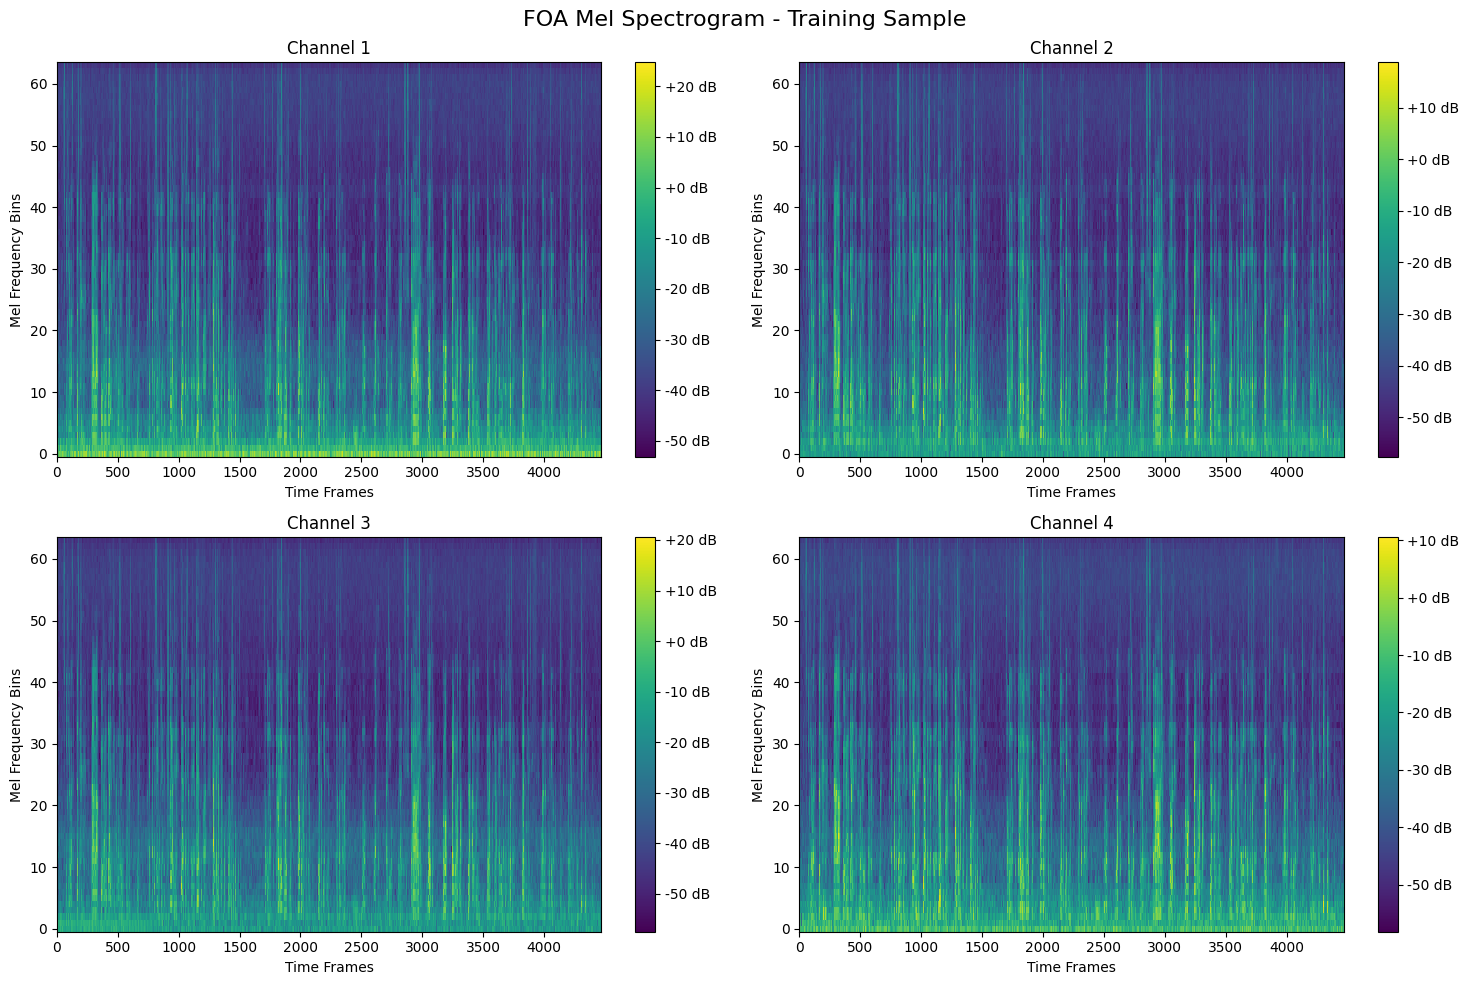

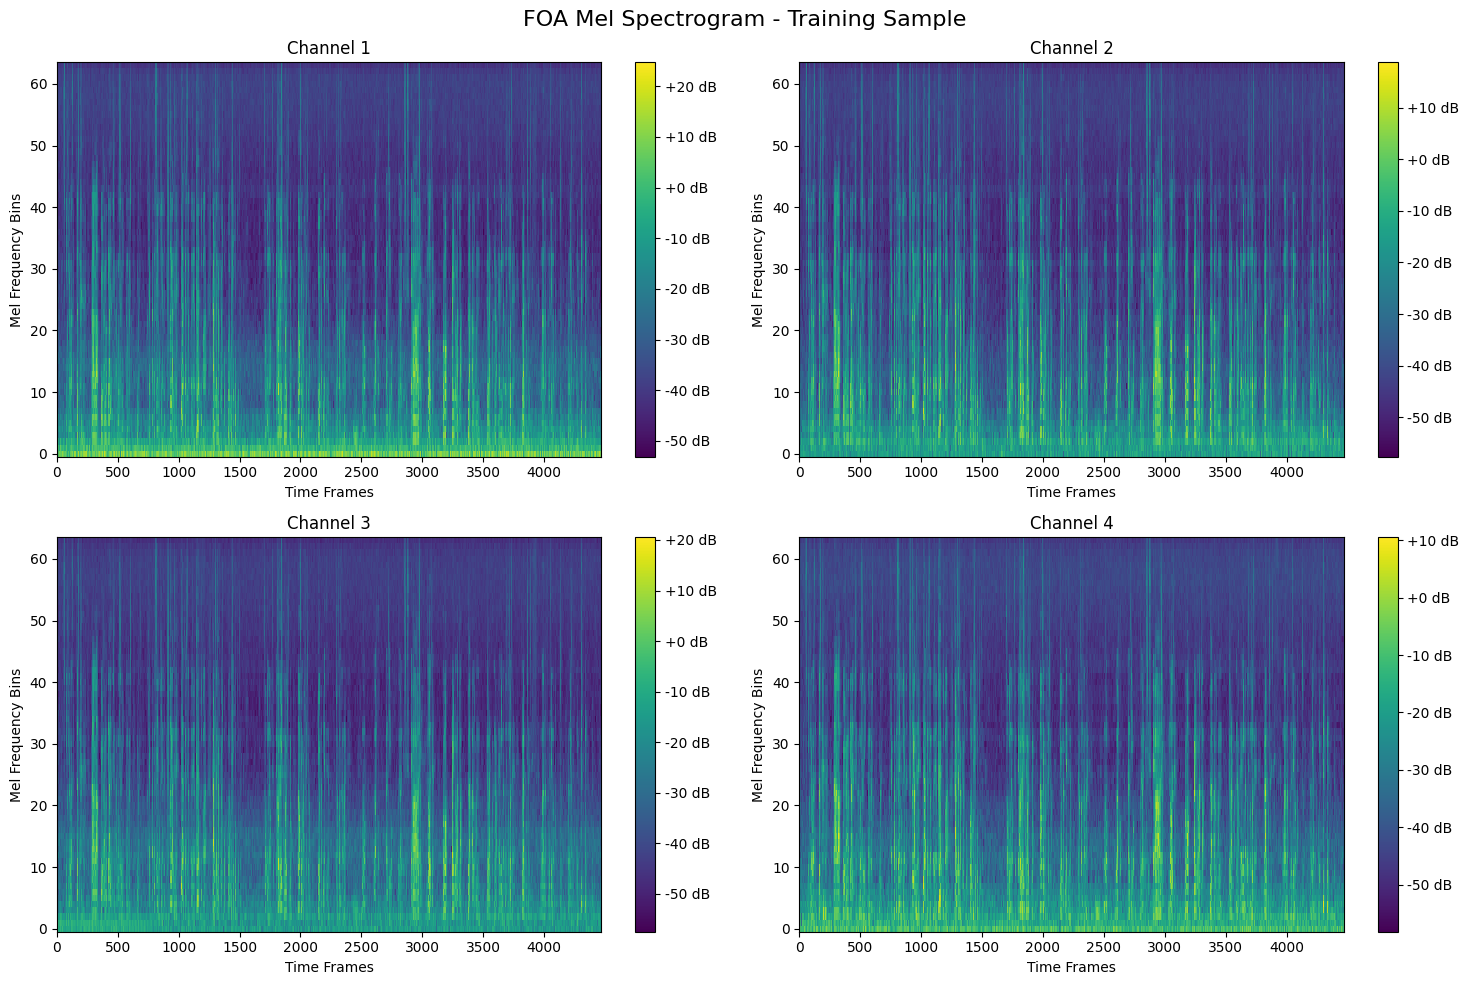

In [38]:
audio, sr = load_audio(train_audio_files[0])
print(audio.shape, sr)  # Expecting (4, num_samples) and sample rate
mel_spec = audio_to_mel_spectrogram(audio, sr)
print(f"Mel spectrogram shape: {mel_spec.shape}")
visualize_mel_spectrogram(mel_spec, title="FOA Mel Spectrogram - Training Sample")

In [39]:
def metadata_to_labels(metadata_path, audio_duration, sample_rate=24000, I=None, J=None, 
                        cell_size_deg=None, num_classes=14):
    """
    Convert metadata file to target labels for 2D grid representation.
    
    Args:
        metadata_path: Path to the CSV metadata file
        audio_duration: Duration of audio in seconds
        sample_rate: Sample rate of audio (default: 24000 Hz)
        I: Number of elevation bins (height of grid)
        J: Number of azimuth bins (width of grid)
        cell_size_deg: Cell size in degrees (alternative to I, J)
        num_classes: Total number of classes including background (default: 14)
        
    Returns:
        labels: Tensor of shape [T', I*J, M] where:
                T' = number of 20ms frames
                I*J = total grid cells
                M = number of classes (14)
    """
    # Use config default if not provided
    if cell_size_deg is None:
        cell_size_deg = config.GRID_CELL_DEGREES
    
    # Step 1: Calculate total number of frames (20ms per frame)
    frame_duration_ms = 20  # 20ms per frame in final representation
    metadata_frame_duration_ms = 100  # 100ms per frame in metadata
    frames_per_metadata_frame = metadata_frame_duration_ms // frame_duration_ms  # = 5
    
    # Total number of frames for the audio
    total_frames = int((audio_duration * 1000) / frame_duration_ms)
    
    # Calculate grid dimensions if not provided
    if (I is None or J is None) and cell_size_deg is not None:
        I = int(180 // cell_size_deg)
        J = int(360 // cell_size_deg)
    elif I is None or J is None:
        raise ValueError("Either provide (I, J) or cell_size_deg for grid dimensions")
    
    total_cells = I * J
    
    # Initialize labels tensor: [T', I*J, M] with all zeros
    labels = torch.zeros((total_frames, total_cells, num_classes), dtype=torch.float32)
    
    # Read metadata CSV
    df = pd.read_csv(metadata_path, header=None)
    
    # Track which cells have active events for each frame
    # This will help us set background (class 13) for empty cells
    active_cells_per_frame = [set() for _ in range(total_frames)]
    
    # Process each row in metadata
    for _, row in df.iterrows():
        # Parse metadata row: [frame, class, source, azimuth, elevation]
        metadata_frame = int(row.iloc[0])  # Frame number from metadata
        active_class = int(row.iloc[1])     # Active class index
        source_num = int(row.iloc[2])       # Source number (not used in labeling)
        azimuth = int(row.iloc[3])          # Azimuth in degrees
        elevation = int(row.iloc[4])        # Elevation in degrees
        
        # Step 2: Map metadata frame to final representation frames
        # Metadata frame t corresponds to frames t*5 to t*5+4 in final representation
        start_frame = metadata_frame * frames_per_metadata_frame
        end_frame = start_frame + frames_per_metadata_frame
        
        # Ensure we don't exceed total frames
        end_frame = min(end_frame, total_frames)
        
        # Step 3: Convert polar coordinates to grid cell
        i, j = polar_to_grid(azimuth, elevation, I=I, J=J)
        cell_idx = i * J + j  # Flatten 2D grid to 1D index
        
        # Step 4: Set active class for this cell across the time frames
        for t in range(start_frame, end_frame):
            # Set the active class to 1 (one-hot encoding)
            labels[t, cell_idx, active_class] = 1.0
            # Track that this cell has an active event
            active_cells_per_frame[t].add(cell_idx)
    
    # Step 5: Set background class (index 13) for cells with no active events
    for t in range(total_frames):
        for cell_idx in range(total_cells):
            # If this cell has no active events in this frame
            if cell_idx not in active_cells_per_frame[t]:
                # Set background class (index 13) to 1
                labels[t, cell_idx, num_classes - 1] = 1.0
    
    # Reshape to [T' * (I*J), M] if needed for certain loss functions
    # For now, keep as [T', I*J, M] for clarity
    
    return labels, I, J

In [40]:
# Test the metadata_to_labels function
audio, sr = load_audio(train_audio_files[0])
audio_duration = audio.shape[1] / sr  # Duration in seconds

# Generate labels with cell_size_deg = 10 (resulting in 18x36 grid)
labels, I, J = metadata_to_labels(
    train_meta_files[0], 
    audio_duration, 
    sample_rate=sr,
    cell_size_deg=10
)

print(f"Labels shape: {labels.shape}")
print(f"Grid dimensions: I={I}, J={J}, Total cells={I*J}")
print(f"Number of frames: {labels.shape[0]}")
print(f"Number of classes: {labels.shape[2]}")
print(f"\nSample label for frame 0, cell 0: {labels[0, 0]}")
print(f"Active class in frame 0, cell 0: {torch.argmax(labels[0, 0]).item()}")

Labels shape: torch.Size([4470, 648, 14])
Grid dimensions: I=18, J=36, Total cells=648
Number of frames: 4470
Number of classes: 14

Sample label for frame 0, cell 0: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Active class in frame 0, cell 0: 13


In [41]:
print(f"Active class in frame 0, cell 0: {torch.argmax(labels[61, 0]).item()}")

Active class in frame 0, cell 0: 13


In [42]:
print(f"Labels shape: {labels.shape}")
print(f"Grid dimensions: I={I}, J={J}, Total cells={I*J}")
print(f"Number of frames: {labels.shape[0]}")
print(f"Number of classes: {labels.shape[2]}")
print(f"\nSample label for frame 0, cell 0: {labels[0, 0]}")
print(f"Active class in frame 0, cell 0: {torch.argmax(labels[0, 0]).item()}")

Labels shape: torch.Size([4470, 648, 14])
Grid dimensions: I=18, J=36, Total cells=648
Number of frames: 4470
Number of classes: 14

Sample label for frame 0, cell 0: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Active class in frame 0, cell 0: 13


In [43]:
i, j = polar_to_grid(-98, -16, I=18, J=36)
print(i, j)
I = 18
J = 36
print(f"Active class in frame 0, cell 0: {torch.argmax(labels[63, i*J + j]).item()}")
print(train_meta_files[0])

7 8
Active class in frame 0, cell 0: 1
c:\Nived\Nived Personal\Academia\NYU\NYU 2-1\Spatial Audio RA\Code\metadata_dev\dev-train-sony\fold3_room21_mix001.csv


In [44]:
print(labels[63].shape)

torch.Size([648, 14])


In [45]:
class SELDDataset(Dataset):
    """
    Dataset class for Sound Event Localization and Detection (SELD).
    
    Loads all audio files, concatenates spectrograms and labels, then segments
    into fixed-length windows with overlap for training.
    """
    
    def __init__(self, audio_files, metadata_files, num_classes=14):
        """
        Initialize SELD Dataset with windowing.
        
        This dataset:
        1. Loads all audio files and computes spectrograms + labels
        2. Concatenates all spectrograms and labels into single tensors
        3. Segments concatenated data into windows (5s window, 1s hop)
        4. Pads final window if needed
        
        Args:
            audio_files: List of audio file paths
            metadata_files: List of corresponding metadata CSV file paths
            num_classes: Total number of classes including background (default: 14)
        """
        assert len(audio_files) == len(metadata_files), \
            "Number of audio files must match number of metadata files"
        
        self.audio_files = audio_files
        self.metadata_files = metadata_files
        self.sample_rate = config.SR
        self.n_fft = config.SPECTROGRAM_N_FFT
        self.spectrogram_hop_length = config.SPECTROGRAM_HOP_LENGTH
        self.n_mels = config.N_MELS
        self.cell_size_deg = config.GRID_CELL_DEGREES
        self.num_classes = num_classes
        
        # Calculate grid dimensions
        self.I = int(180 // self.cell_size_deg)
        self.J = int(360 // self.cell_size_deg)
        self.total_cells = self.I * self.J
        
        # Window parameters (in samples)
        self.window_length_samples = config.WINDOW_LENGTH  # 5s in samples
        self.hop_length_samples = config.HOP_LENGTH  # 1s in samples
        
        # Convert to spectrogram frames
        # Each spectrogram frame represents spectrogram_hop_length samples
        self.window_length_frames = int(self.window_length_samples / self.spectrogram_hop_length)
        self.hop_length_frames = int(self.hop_length_samples / self.spectrogram_hop_length)
        
        logger.info(f"SELDDataset initialization started...")
        logger.info(f"  Files: {len(audio_files)} audio files")
        logger.info(f"  Grid: {self.I}x{self.J} = {self.total_cells} cells")
        logger.info(f"  Window: {self.window_length_frames} frames ({self.window_length_samples / self.sample_rate:.1f}s)")
        logger.info(f"  Hop: {self.hop_length_frames} frames ({self.hop_length_samples / self.sample_rate:.1f}s)")
        
        # Step 1 & 2: Load all files and concatenate
        self._load_and_concatenate_all()
        
        # Step 3 & 4: Segment into windows
        self._create_windows()
        
        logger.info(f"SELDDataset initialized with {len(self.windows)} windows")
    
    def _load_and_concatenate_all(self):
        """Load all files, compute spectrograms and labels, then concatenate."""
        all_spectrograms = []
        all_labels = []
        
        logger.info("Loading and processing all audio files...")
        for idx, (audio_path, metadata_path) in enumerate(tqdm(
            zip(self.audio_files, self.metadata_files),
            total=len(self.audio_files),
            desc="Processing files"
        )):
            try:
                # Load audio
                waveform, sr = load_audio(audio_path)
                
                # Compute mel spectrogram
                mel_spec = audio_to_mel_spectrogram(
                    waveform, 
                    sr,
                    n_fft=self.n_fft,
                    hop_length=self.spectrogram_hop_length,
                    n_mels=self.n_mels
                )  # Shape: (4, n_mels, time_frames)
                
                # Calculate audio duration
                audio_duration = waveform.shape[1] / sr
                
                # Generate labels from metadata
                labels, _, _ = metadata_to_labels(
                    metadata_path,
                    audio_duration,
                    sample_rate=sr,
                    I=self.I,
                    J=self.J,
                    cell_size_deg=self.cell_size_deg,
                    num_classes=self.num_classes
                )  # Shape: (time_frames, I*J, num_classes)
                
                # Ensure matching time dimensions
                mel_time_frames = mel_spec.shape[2]
                label_time_frames = labels.shape[0]
                
                if mel_time_frames != label_time_frames:
                    min_frames = min(mel_time_frames, label_time_frames)
                    mel_spec = mel_spec[:, :, :min_frames]
                    labels = labels[:min_frames, :, :]
                
                # Append to lists
                all_spectrograms.append(mel_spec)
                all_labels.append(labels)
                
            except Exception as e:
                logger.error(f"Error processing file {idx} ({audio_path}): {str(e)}")
                raise
        
        # Concatenate along time dimension
        self.concatenated_spectrograms = torch.cat(all_spectrograms, dim=2)  # (4, n_mels, T)
        self.concatenated_labels = torch.cat(all_labels, dim=0)  # (T, I*J, num_classes)
        
        self.total_frames = self.concatenated_spectrograms.shape[2]
        logger.info(f"Concatenated data: {self.total_frames} total frames")
        logger.info(f"  Spectrograms shape: {self.concatenated_spectrograms.shape}")
        logger.info(f"  Labels shape: {self.concatenated_labels.shape}")
    
    def _create_windows(self):
        """Segment concatenated data into windows with overlap."""
        self.windows = []
        
        start_frame = 0
        window_idx = 0
        
        while start_frame < self.total_frames:
            end_frame = start_frame + self.window_length_frames
            
            # Extract window
            if end_frame <= self.total_frames:
                # Normal window - no padding needed
                window_spec = self.concatenated_spectrograms[:, :, start_frame:end_frame]
                window_labels = self.concatenated_labels[start_frame:end_frame, :, :]
            else:
                # Last window - needs padding
                actual_frames = self.total_frames - start_frame
                
                # Extract what we have
                window_spec = self.concatenated_spectrograms[:, :, start_frame:]
                window_labels = self.concatenated_labels[start_frame:, :, :]
                
                # Pad to window_length_frames
                pad_frames = self.window_length_frames - actual_frames
                
                # Pad spectrograms: (4, n_mels, time) -> pad time dimension
                spec_pad = torch.zeros((4, self.n_mels, pad_frames), dtype=window_spec.dtype)
                window_spec = torch.cat([window_spec, spec_pad], dim=2)
                
                # Pad labels: (time, I*J, num_classes) -> pad time dimension
                # Set background class (index 13) for padded frames
                label_pad = torch.zeros((pad_frames, self.total_cells, self.num_classes), dtype=window_labels.dtype)
                label_pad[:, :, self.num_classes - 1] = 1.0  # Set background class
                window_labels = torch.cat([window_labels, label_pad], dim=0)
            
            # Transpose spectrogram from [C, F, T] to [T, C, F]
            window_spec = window_spec.permute(2, 0, 1)  # (T, C, F)
            
            # Store window
            self.windows.append({
                'spectrogram': window_spec,
                'labels': window_labels,
                'window_idx': window_idx,
                'start_frame': start_frame,
                'end_frame': min(end_frame, self.total_frames)
            })
            
            # Move to next window
            start_frame += self.hop_length_frames
            window_idx += 1
        
        logger.info(f"Created {len(self.windows)} windows")
    
    def __len__(self):
        """Return the number of windows in the dataset."""
        return len(self.windows)
    
    def __getitem__(self, idx):
        """
        Get a single window from the dataset.
        
        Args:
            idx: Window index
            
        Returns:
            spectrogram: Mel spectrogram tensor of shape (window_length_frames, 4, n_mels) - [T, C, F]
            labels: Target labels tensor of shape (window_length_frames, I*J, num_classes) - [T, I*J, M]
        """
        window = self.windows[idx]
        return window['spectrogram'], window['labels']

## SELDDataset with Windowing

The `SELDDataset` class implements a windowing approach for SELD training:

### Workflow:
1. **Load all files**: Each audio file is loaded and processed to extract:
   - Mel spectrogram: shape `(4, 64, T_i)` for file i
   - Labels: shape `(T_i, 648, 14)` for file i

2. **Concatenate**: All spectrograms and labels are concatenated along the time dimension:
   - Concatenated spectrogram: `(4, 64, T)` where T = sum of all T_i
   - Concatenated labels: `(T, 648, 14)`

3. **Segment into windows**: The concatenated data is segmented into fixed-length windows:
   - Window length: 5 seconds = 250 frames (at 20ms per frame)
   - Hop length: 1 second = 50 frames
   - Overlap: 4 seconds (200 frames) between consecutive windows

4. **Padding**: The final window is padded if it has fewer than 250 frames:
   - Spectrograms: padded with zeros
   - Labels: padded with background class (index 13 = 1.0)

5. **Transpose**: Spectrograms are transposed from `[C, F, T]` to `[T, C, F]` format

### Output:
Each window provides:
- Spectrogram: `(250, 4, 64)` - **[T, C, F]** format: 250 time frames, 4 channels, 64 mel bins
- Labels: `(250, 648, 14)` - **[T, I×J, M]** format: 250 time frames, 648 spatial cells, 14 classes

This ensures all training samples have consistent shapes and can be batched efficiently.

This ensures all training samples have consistent shapes and can be batched efficiently.

In [46]:
# Test SELDDataset with a small subset
print("Creating windowed dataset...")
test_dataset = SELDDataset(
    audio_files=train_audio_files[:2],  # Use first 2 files for testing
    metadata_files=train_meta_files[:2],
    num_classes=14
)

print(f"\nDataset info:")
print(f"  Number of windows: {len(test_dataset)}")
print(f"  Grid dimensions: {test_dataset.I}x{test_dataset.J} = {test_dataset.total_cells} cells")
print(f"  Window length: {test_dataset.window_length_frames} frames")
print(f"  Hop length: {test_dataset.hop_length_frames} frames")

# Get a single window
spec, labels = test_dataset[0]
print(f"\nWindow 0:")
print(f"  Spectrogram shape: {spec.shape}")  # (4, n_mels, window_length_frames)
print(f"  Labels shape: {labels.shape}")  # (window_length_frames, I*J, num_classes)

# Test with DataLoader
print(f"\nTesting DataLoader...")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0  # Set to 0 for testing
)

# Get a batch
for batch_idx, (batch_specs, batch_labels) in enumerate(test_dataloader):
    print(f"Batch {batch_idx}:")
    print(f"  Batch spectrograms shape: {batch_specs.shape}")  # (batch, 4, n_mels, window_length_frames)
    print(f"  Batch labels shape: {batch_labels.shape}")  # (batch, window_length_frames, I*J, num_classes)
    break  # Only show first batch

Creating windowed dataset...
2025-11-16 20:47:57 - SMR_SELD - INFO - SELDDataset initialization started...
2025-11-16 20:47:57 - SMR_SELD - INFO -   Files: 2 audio files
2025-11-16 20:47:57 - SMR_SELD - INFO -   Grid: 18x36 = 648 cells
2025-11-16 20:47:57 - SMR_SELD - INFO -   Window: 250 frames (5.0s)
2025-11-16 20:47:57 - SMR_SELD - INFO -   Hop: 50 frames (1.0s)
2025-11-16 20:47:57 - SMR_SELD - INFO - Loading and processing all audio files...
2025-11-16 20:47:57 - SMR_SELD - INFO -   Files: 2 audio files
2025-11-16 20:47:57 - SMR_SELD - INFO -   Grid: 18x36 = 648 cells
2025-11-16 20:47:57 - SMR_SELD - INFO -   Window: 250 frames (5.0s)
2025-11-16 20:47:57 - SMR_SELD - INFO -   Hop: 50 frames (1.0s)
2025-11-16 20:47:57 - SMR_SELD - INFO - Loading and processing all audio files...


Processing files: 100%|██████████| 2/2 [00:53<00:00, 26.90s/it]



2025-11-16 20:48:51 - SMR_SELD - INFO - Concatenated data: 11470 total frames
2025-11-16 20:48:51 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 11470])
2025-11-16 20:48:51 - SMR_SELD - INFO -   Labels shape: torch.Size([11470, 648, 14])
2025-11-16 20:48:51 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 11470])
2025-11-16 20:48:51 - SMR_SELD - INFO -   Labels shape: torch.Size([11470, 648, 14])
2025-11-16 20:48:51 - SMR_SELD - INFO - Created 230 windows
2025-11-16 20:48:51 - SMR_SELD - INFO - SELDDataset initialized with 230 windows
2025-11-16 20:48:51 - SMR_SELD - INFO - Created 230 windows
2025-11-16 20:48:51 - SMR_SELD - INFO - SELDDataset initialized with 230 windows

Dataset info:
  Number of windows: 230
  Grid dimensions: 18x36 = 648 cells
  Window length: 250 frames
  Hop length: 50 frames

Window 0:
  Spectrogram shape: torch.Size([250, 4, 64])
  Labels shape: torch.Size([250, 648, 14])

Testing DataLoader...
Batch 0:
  Batch spectrograms shape: tor

In [47]:
# Create full train and test datasets
# Uncomment when ready to use full dataset

# print("Creating full train dataset...")
# train_dataset = SELDDataset(
#     audio_files=train_audio_files,
#     metadata_files=train_meta_files,
#     num_classes=14
# )

# print("\nCreating full test dataset...")
# test_dataset = SELDDataset(
#     audio_files=test_audio_files,
#     metadata_files=test_meta_files,
#     num_classes=14
# )

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=8,
#     shuffle=True,
#     num_workers=4,
#     pin_memory=True if torch.cuda.is_available() else False
# )

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=4,
#     pin_memory=True if torch.cuda.is_available() else False
# )

# print(f"\nTrain dataset: {len(train_dataset)} windows")
# print(f"Test dataset: {len(test_dataset)} windows")
# print(f"Train batches: {len(train_loader)}")
# print(f"Test batches: {len(test_loader)}")

### Model


In [ ]:
class Conv(nn.Module):
    """Standard convolution with BN and SiLU activation"""
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU(inplace=True)
    
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class Bottleneck(nn.Module):
    """Standard bottleneck block with residual connection"""
    def __init__(self, in_channels, out_channels, shortcut=True):
        super().__init__()
        self.cv1 = Conv(in_channels, out_channels, 1, 1, 0)
        self.cv2 = Conv(out_channels, out_channels, 3, 1, 1)
        self.add = shortcut and in_channels == out_channels
    
    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class C3(nn.Module):
    """CSP Bottleneck with 3 convolutions"""
    def __init__(self, in_channels, out_channels, n_blocks=1, shortcut=True):
        super().__init__()
        hidden_channels = out_channels // 2
        self.cv1 = Conv(in_channels, hidden_channels, 1, 1, 0)
        self.cv2 = Conv(in_channels, hidden_channels, 1, 1, 0)
        self.cv3 = Conv(2 * hidden_channels, out_channels, 1, 1, 0)
        self.m = nn.Sequential(
            *[Bottleneck(hidden_channels, hidden_channels, shortcut) for _ in range(n_blocks)]
        )
    
    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), dim=1))

class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast"""
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        hidden_channels = in_channels // 2
        self.cv1 = Conv(in_channels, hidden_channels, 1, 1, 0)
        self.cv2 = Conv(hidden_channels * 4, out_channels, 1, 1, 0)
        self.m = nn.MaxPool2d(kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
    
    def forward(self, x):
        x = self.cv1(x)
        y1 = self.m(x)
        y2 = self.m(y1)
        y3 = self.m(y2)
        return self.cv2(torch.cat([x, y1, y2, y3], dim=1))

class CSPDarkNet53(nn.Module):
    """CSPDarkNet53 backbone for audio SELD"""
    def __init__(self, in_channels=4, base_channels=64, depth_multiple=1.0, width_multiple=1.0):
        super().__init__()
        
        def get_channels(c):
            return max(round(c * width_multiple), 1)
        
        def get_depth(n):
            return max(round(n * depth_multiple), 1)
        
        # 3x3 stem for audio
        self.stem = Conv(in_channels, get_channels(base_channels), 3, 1, 1)
        
        self.stage1 = nn.Sequential(
            Conv(get_channels(64), get_channels(128), 3, 2, 1),
            C3(get_channels(128), get_channels(128), n_blocks=get_depth(3))
        )
        
        self.stage2 = nn.Sequential(
            Conv(get_channels(128), get_channels(256), 3, 2, 1),
            C3(get_channels(256), get_channels(256), n_blocks=get_depth(6))
        )
        
        self.stage3 = nn.Sequential(
            Conv(get_channels(256), get_channels(512), 3, 2, 1),
            C3(get_channels(512), get_channels(512), n_blocks=get_depth(9))
        )
        
        self.stage4 = nn.Sequential(
            Conv(get_channels(512), get_channels(1024), 3, 2, 1),
            C3(get_channels(1024), get_channels(1024), n_blocks=get_depth(3)),
            SPPF(get_channels(1024), get_channels(1024))
        )
        
        self.out_channels = [
            get_channels(128),   # P2
            get_channels(256),   # P3
            get_channels(512),   # P4
            get_channels(1024)   # P5
        ]
    
    def forward(self, x):
        x = self.stem(x)
        p2 = self.stage1(x)
        p3 = self.stage2(p2)
        p4 = self.stage3(p3)
        p5 = self.stage4(p4)
        return [p2, p3, p4, p5]

class SMRSELDWithCSPDarkNet(nn.Module):
    """
    SMR‑SELD model with a CSPDarkNet53 backbone.

    Input shape: [batch_size, 250, 4, 64] - [B, T, C, F]
    Output shape: [batch_size, 250, I*J, num_classes] - [B, T, grid_cells, M]

    Parameters
    ----------
    n_channels : int
        Number of input channels (4 for FOA).
    grid_size : tuple of int
        (I, J) specifying number of elevation and azimuth bins (e.g., (18, 36) for 10° resolution).
    num_classes : int
        Number of event classes including background (14).
    use_small : bool
        If True, use a reduced backbone (depth and width multipliers).
    """
    def __init__(self, n_channels=4, grid_size=(18, 36), num_classes=14, use_small=True):
        super().__init__()
        self.I, self.J = grid_size
        self.grid_cells = self.I * self.J
        self.num_classes = num_classes

        # CSPDarkNet53 backbone
        if use_small:
            self.backbone = CSPDarkNet53(in_channels=n_channels, depth_multiple=0.33, width_multiple=0.5)
        else:
            self.backbone = CSPDarkNet53(in_channels=n_channels)

        # Multi‑scale fusion
        self.fusion = nn.ModuleList([
            nn.Conv2d(self.backbone.out_channels[1], 256, 1),  # P3
            nn.Conv2d(self.backbone.out_channels[2], 256, 1),  # P4
            nn.Conv2d(self.backbone.out_channels[3], 256, 1),  # P5
        ])

        self.conv_fuse = nn.Sequential(
            nn.Conv2d(256 * 3, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.SiLU(),
            nn.Conv2d(512, 256, 1),
            nn.BatchNorm2d(256),
            nn.SiLU()
        )

        # Pooling layer that resamples feature maps to exactly `grid_cells` rows.
        # We treat the frequency dimension as the vertical axis and collapse the
        # singleton width dimension.  AdaptiveAvgPool2d with output size
        # `(grid_cells, 1)` produces a feature vector for each grid cell.
        self.grid_pool = nn.AdaptiveAvgPool2d((self.grid_cells, 1))

        # Classifier head applied to each grid cell independently.  Input
        # dimension matches the number of channels after fusion (256).
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        """
        Forward pass of SMR-SELD model.

        Args:
            x: Input tensor of shape [B, T, C, F] = [batch_size, 250, 4, 64]

        Returns:
            Output tensor of shape [B, T, grid_cells, num_classes] = [batch_size, 250, 648, 14]
        """
        B, T, C, F_dim = x.shape  # [batch_size, 250, 4, 64]

        # Reshape to [B*T, C, F, 1] for 2D CNN processing
        # Treat each time frame independently, with frequency as spatial dimension
        x = x.reshape(B * T, C, F_dim, 1)  # [B*T, 4, 64, 1]

        # Pass through backbone - extracts multi-scale features
        features = self.backbone(x)
        p3, p4, p5 = features[1], features[2], features[3]

        # Apply 1x1 convolutions for channel reduction
        p3 = self.fusion[0](p3)  # [B*T, 256, H3, W3]
        p4 = self.fusion[1](p4)  # [B*T, 256, H4, W4]
        p5 = self.fusion[2](p5)  # [B*T, 256, H5, W5]

        # Upsample all to same spatial size (align to p3)
        target_size = p3.shape[2:]
        p4 = F.interpolate(p4, size=target_size, mode='bilinear', align_corners=False)
        p5 = F.interpolate(p5, size=target_size, mode='bilinear', align_corners=False)

        # Concatenate multi-scale features
        fused = torch.cat([p3, p4, p5], dim=1)  # [B*T, 768, H, W]
        x = self.conv_fuse(fused)  # [B*T, 256, H, W]

        # Resample feature maps to the number of grid cells.  Treat the
        # frequency axis as the vertical dimension and the singleton width
        # axis as horizontal.  This yields a tensor of shape
        # [B*T, 256, grid_cells, 1].
        x = self.grid_pool(x)  # [B*T, 256, grid_cells, 1]

        # Remove the trailing width dimension and transpose to
        # [B*T, grid_cells, 256] so each cell has its own feature vector.
        x = x.squeeze(-1).permute(0, 2, 1)  # [B*T, G, 256]

        # Apply the classifier independently to each cell.  The linear layer
        # will broadcast over the grid dimension.  Output shape:
        # [B*T, G, num_classes].
        x = self.classifier(x)  # [B*T, G, M]

        # Reshape back to [B, T, G, M]
        x = x.view(B, T, self.grid_cells, self.num_classes)

        # Apply softmax along the class dimension
        return F.softmax(x, dim=-1)

In [ ]:
class SMRSELDLoss(nn.Module):
    """
    Complete SMR‑SELD loss function with three components:
    class MSE, AIUR and converging localization.  The grid dimensions (I, J)
    are needed for the localization loss; they are derived from the
    configuration at initialization.
    """

    def __init__(self, w_class=1.0, w_aiur=0.5, w_cl=0.5, grid_size=None):
        super().__init__()
        self.w_class = w_class
        self.w_aiur = w_aiur
        self.w_cl = w_cl
        # grid_size should be a tuple (I, J).  If None, we assume square grid.
        if grid_size is not None:
            self.I, self.J = grid_size
        else:
            self.I = self.J = None
    
    def class_mse_loss(self, y_pred, y_true):
        """Class-wise Mean Squared Error loss with class weighting
        
        Apply higher weight to event classes (first 13) vs background (last).
        This handles the severe class imbalance (~99.8% background).
        
        Args:
            y_pred: Predicted output (B, T, G, M) where M = num_classes
            y_true: Ground truth labels (B, T, G, M)
        
        Returns:
            Weighted MSE loss (scalar tensor)
        """
        # # Get dimensions
        # B, T, G, M = y_pred.shape
        
        # # Background class is the last index (index 13 for 14 classes)
        # background_idx = M - 1
        
        # # Create masks for event and background cells
        # # A cell has an event if any non-background class has value 1
        # # We check the true labels to determine which cells have events
        # y_true_class = torch.argmax(y_true, dim=-1)  # (B, T, G) - get class index
        
        # # Mask for cells with events (non-background)
        # event_mask = (y_true_class != background_idx)  # (B, T, G)
        
        # # Mask for background cells
        # background_mask = (y_true_class == background_idx)  # (B, T, G)
        
        # # Compute squared error for all cells and all classes
        # squared_error = (y_pred - y_true) ** 2  # (B, T, G, M)
        
        # # Sum across class dimension to get per-cell error
        # squared_error_per_cell = squared_error.sum(dim=-1)  # (B, T, G)
        
        # # Separate losses for event cells and background cells
        # if event_mask.sum() > 0:
        #     event_loss = squared_error_per_cell[event_mask].mean()
        # else:
        #     event_loss = torch.tensor(0.0, device=y_pred.device)
        
        # if background_mask.sum() > 0:
        #     background_loss = squared_error_per_cell[background_mask].mean()
        # else:
        #     background_loss = torch.tensor(0.0, device=y_pred.device)
        
        # # Apply weighted loss: higher weight for event classes to handle imbalance
        # # Using 10:1 ratio as suggested in the original implementation
        # weighted_loss = 10.0 * event_loss + 1.0 * background_loss
        
        # return weighted_loss
        mse_loss = F.mse_loss(y_pred, y_true, reduction='mean')
        return mse_loss
        

    
    def aiur_loss(self, y_pred, y_true):
        """Area Intersection Union Ratio (AIUR) loss computed per frame and batch.

        We compute the IoU for each frame in each sequence and average the results.
        This encourages the model to improve IoU locally rather than aggregating
        everything into a single global statistic, which can remain near 1 when
        the model predicts only background.
        
        Args:
            y_pred: Predicted output (B, T, G, M) where M = num_classes
            y_true: Ground truth labels (B, T, G, M)
        
        Returns:
            AIUR loss (scalar tensor): 1 - average_IoU across all frames and batches
        """
        # Get dimensions
        B, T, G, M = y_pred.shape
        
        # Background class is the last index (index 13 for 14 classes)
        background_idx = M - 1
        
        # Get predicted and true class indices
        y_pred_class = torch.argmax(y_pred, dim=-1)  # (B, T, G)
        y_true_class = torch.argmax(y_true, dim=-1)  # (B, T, G)
        
        # Create binary masks: 1 for event cells, 0 for background
        pred_event_mask = (y_pred_class != background_idx).float()  # (B, T, G)
        true_event_mask = (y_true_class != background_idx).float()  # (B, T, G)
        
        # Compute IoU for each frame in each batch
        # IoU = intersection / union
        # intersection = cells that have events in BOTH pred and true
        # union = cells that have events in EITHER pred or true
        
        # Intersection: element-wise multiplication
        intersection = (pred_event_mask * true_event_mask).sum(dim=-1)  # (B, T) - sum over grid cells
        
        # Union: sum of both masks minus intersection
        # Union = |A| + |B| - |A ∩ B|
        pred_count = pred_event_mask.sum(dim=-1)  # (B, T)
        true_count = true_event_mask.sum(dim=-1)  # (B, T)
        union = pred_count + true_count - intersection  # (B, T)
        
        # Compute IoU for each frame
        # Add small epsilon to avoid division by zero
        epsilon = 1e-8
        iou = intersection / (union + epsilon)  # (B, T)
        
        # Handle edge case where both pred and true have no events (union = 0)
        # In this case, IoU should be 1.0 (perfect match of empty sets)
        iou = torch.where(union > 0, iou, torch.ones_like(iou))
        
        # Average IoU across all frames and batches
        avg_iou = iou.mean()
        
        # AIUR loss = 1 - IoU
        aiur_loss_value = 1.0 - avg_iou
        
        return aiur_loss_value

    
    def converging_localization_loss(self, y_pred, y_true):
        """Converging Localization loss
        
        This loss encourages predictions to converge towards dense non-background areas.
        It guides the prediction results from surrounding areas to the target location,
        reducing extreme category imbalance and strengthening regression positioning ability.
        
        From the paper:
        1. Transform targets: y'_ij = 1 for background cells, -N_bac/N_non_bac for event cells
        2. Calculate attention: yat_ij = y'_ij + AVG(surroundings - y'_ij)
        3. Loss: LCL = Σ(ŷ_ij × yat_ij) / total_cells
        
        Args:
            y_pred: Predicted output (B, T, G, M) where M = num_classes
            y_true: Ground truth labels (B, T, G, M)
        
        Returns:
            Converging localization loss (scalar tensor)
        """
        # Get dimensions
        B, T, G, M = y_pred.shape
        # Determine grid dimensions
        if self.I is not None and self.J is not None:
            I, J = self.I, self.J
        else:
            I = J = int(math.sqrt(G))
        # Reshape to (B, T, I, J)
        true_nonbg = y_true[..., :-1].sum(dim=-1).view(B, T, I, J)
        pred_nonbg = y_pred[..., :-1].sum(dim=-1).view(B, T, I, J)
        # Count per frame
        N_bac = (true_nonbg < 0.01).sum(dim=(2, 3), keepdim=True).float()
        N_non_bac = (true_nonbg > 0.01).sum(dim=(2, 3), keepdim=True).float()
        # Initialise y_prime: 1 for background, negative ratio for events
        y_prime = torch.ones_like(true_nonbg)
        ratio = -(N_bac / (N_non_bac + 1e-10))
        y_prime = torch.where(true_nonbg > 0.01, ratio.expand_as(true_nonbg), y_prime)
        # Compute neighbourhood average using circular padding
        y_prime_padded = F.pad(y_prime, (1, 1, 1, 1), mode='circular')  # pad (left,right,top,bottom)
        diff_sum = torch.zeros_like(y_prime)
        for di in (-1, 0, 1):
            for dj in (-1, 0, 1):
                if di == 0 and dj == 0:
                    continue
                neighbor = y_prime_padded[:, :, 1+di:I+1+di, 1+dj:J+1+dj]
                diff_sum += (neighbor - y_prime)
        avg_diff = diff_sum / 8.0
        y_at = y_prime + avg_diff
        # Mask frames without events
        has_events_mask = (N_non_bac > 0).float()
        loss = ((pred_nonbg * y_at) * has_events_mask).sum() / (B * T + 1e-10)
        return loss


    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        """
        Compute the weighted sum of the three loss components and return
        both the total loss and a breakdown of individual components.  This
        method is called when the loss module is invoked like a function,
        e.g., `loss, breakdown = criterion(pred, target)`.

        Parameters
        ----------
        y_pred : torch.Tensor
            Predicted output of shape (B, T, G, M), where B is batch size,
            T is the number of frames in a sequence, G is the number of
            grid cells and M is the number of classes.
        y_true : torch.Tensor
            Ground‑truth targets with the same shape as ``y_pred``.

        Returns
        -------
        total_loss : torch.Tensor
            Scalar tensor containing the weighted sum of the three loss terms.
        breakdown : dict
            Dictionary with keys ``'class_mse'``, ``'aiur'`` and ``'cl'`` mapping
            to the individual component losses (Python floats).
        """
        # Compute individual losses
        loss_class = self.class_mse_loss(y_pred, y_true)
        loss_aiur = self.aiur_loss(y_pred, y_true)
        loss_cl = self.converging_localization_loss(y_pred, y_true)
        # Weighted sum
        total_loss = (self.w_class * loss_class +
                      self.w_aiur * loss_aiur +
                      self.w_cl * loss_cl)
        # Prepare breakdown for logging
        breakdown = {
            'class_mse': float(loss_class.item()),
            'aiur': float(loss_aiur.item()),
            'cl': float(loss_cl.item())
        }
        return total_loss, breakdown

In [50]:
# # Create train and test datasets
# print("Creating train dataset...")
# train_dataset = SELDDataset(
#     audio_files=train_audio_files,
#     metadata_files=train_meta_files,
#     num_classes=14
# )

# print("\nCreating test dataset...")
# test_dataset = SELDDataset(
#     audio_files=test_audio_files,
#     metadata_files=test_meta_files,
#     num_classes=14
# )

# print(f"\n{'='*60}")
# print(f"Dataset Summary:")
# print(f"{'='*60}")
# print(f"Train dataset: {len(train_dataset)} windows")
# print(f"Test dataset: {len(test_dataset)} windows")
# print(f"Grid dimensions: {train_dataset.I}x{train_dataset.J} = {train_dataset.total_cells} cells")
# print(f"Window length: {train_dataset.window_length_frames} frames ({train_dataset.window_length_samples / train_dataset.sample_rate:.1f}s)")
# print(f"Hop length: {train_dataset.hop_length_frames} frames ({train_dataset.hop_length_samples / train_dataset.sample_rate:.1f}s)") 

### Model Testing - Single Forward Pass

In [51]:
# # Test model with a single window
# print("="*60)
# print("MODEL FORWARD PASS TEST")
# print("="*60)

# # Initialize the model
# model = SMRSELDWithCSPDarkNet(
#     n_channels=4,
#     grid_size=(18, 36),  # 18x36 = 648 cells
#     num_classes=14,
#     use_small=False
# )

# # Move model to device
# model = model.to(DEVICE)
# model.eval()  # Set to evaluation mode

# print(f"\nModel initialized and moved to {DEVICE}")
# print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Get a single window from test dataset
# print("\n" + "-"*60)
# print("Getting a single window from dataset...")
# print("-"*60)

# spec, labels = test_dataset[0]
# print(f"Spectrogram shape: {spec.shape}")  # Expected: (250, 4, 64)
# print(f"Labels shape: {labels.shape}")      # Expected: (250, 648, 14)

# # Add batch dimension and move to device
# spec_batch = spec.unsqueeze(0).to(DEVICE)      # Shape: (1, 250, 4, 64)
# labels_batch = labels.unsqueeze(0).to(DEVICE)  # Shape: (1, 250, 648, 14)

# print(f"\nBatch spectrogram shape: {spec_batch.shape}")  # (1, 250, 4, 64)
# print(f"Batch labels shape: {labels_batch.shape}")      # (1, 250, 648, 14)

# # Forward pass
# print("\n" + "-"*60)
# print("Running forward pass...")
# print("-"*60)

# with torch.no_grad():
#     predictions = model(spec_batch)

# print(f"Predictions shape: {predictions.shape}")  # Expected: (1, 250, 648, 14)

# # Verify dimensions match
# print("\n" + "-"*60)
# print("DIMENSION VERIFICATION")
# print("-"*60)
# print(f"✓ Input shape:       {spec_batch.shape} -> [batch_size, T, C, F]")
# print(f"✓ Output shape:      {predictions.shape} -> [batch_size, T, grid_cells, num_classes]")
# print(f"✓ Ground truth shape: {labels_batch.shape} -> [batch_size, T, grid_cells, num_classes]")
# print(f"✓ Shapes match: {predictions.shape == labels_batch.shape}")

# # Compare predictions with ground truth
# print("\n" + "-"*60)
# print("PREDICTIONS vs GROUND TRUTH COMPARISON")
# print("-"*60)

# # Get predictions for first time frame, first 5 cells
# time_frame = 0
# num_cells_to_show = 5

# print(f"\nTime frame {time_frame}, showing first {num_cells_to_show} cells:")
# print(f"{'Cell':<6} {'Pred Class':<12} {'True Class':<12} {'Pred Prob':<12} {'Match':<6}")
# print("-" * 60)

# for cell_idx in range(num_cells_to_show):
#     pred_class = torch.argmax(predictions[0, time_frame, cell_idx]).item()
#     true_class = torch.argmax(labels_batch[0, time_frame, cell_idx]).item()
#     pred_prob = predictions[0, time_frame, cell_idx, pred_class].item()
#     match = "✓" if pred_class == true_class else "✗"
    
#     print(f"{cell_idx:<6} {pred_class:<12} {true_class:<12} {pred_prob:<12.4f} {match:<6}")

# # Summary statistics
# print("\n" + "-"*60)
# print("SUMMARY STATISTICS")
# print("-"*60)

# # Get predicted and true classes for all frames and cells
# pred_classes = torch.argmax(predictions, dim=-1)  # Shape: (1, 250, 648)
# true_classes = torch.argmax(labels_batch, dim=-1)  # Shape: (1, 250, 648)

# # Calculate accuracy
# accuracy = (pred_classes == true_classes).float().mean().item()
# print(f"Overall accuracy: {accuracy*100:.2f}%")

# # Count predictions per class
# pred_class_counts = torch.bincount(pred_classes.flatten(), minlength=14)
# true_class_counts = torch.bincount(true_classes.flatten(), minlength=14)

# print(f"\nClass distribution:")
# print(f"{'Class':<20} {'Predicted':<12} {'Ground Truth':<12}")
# print("-" * 50)
# for class_idx in range(14):
#     class_name = config.STARSS22_CLASSES.get(class_idx, f"Class {class_idx}")
#     # Truncate long names
#     class_name = class_name[:18] + ".." if len(class_name) > 20 else class_name
#     print(f"{class_name:<20} {pred_class_counts[class_idx].item():<12} {true_class_counts[class_idx].item():<12}")

# print("\n" + "="*60)
# print("MODEL TEST COMPLETED SUCCESSFULLY!")
# print("="*60)
# print("\nNote: Low accuracy is expected for untrained model (random initialization).")

In [52]:
def plot_loss_curves(train_losses, test_losses, save_path=None):
    """
    Plot and save training and test loss curves.
    
    Args:
        train_losses: List of training losses per epoch
        test_losses: List of test losses per epoch
        save_path: Path to save the plot (optional)
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs, test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=4)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Test Loss Curves', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add minimum loss markers
    min_train_idx = train_losses.index(min(train_losses))
    min_test_idx = test_losses.index(min(test_losses))
    
    plt.plot(min_train_idx + 1, train_losses[min_train_idx], 'b*', 
             markersize=15, label=f'Best Train: {train_losses[min_train_idx]:.4f}')
    plt.plot(min_test_idx + 1, test_losses[min_test_idx], 'r*', 
             markersize=15, label=f'Best Test: {test_losses[min_test_idx]:.4f}')
    
    plt.legend(fontsize=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Loss curve saved to {save_path}")
    
    plt.show()
    
    return plt.gcf()

In [53]:
def train_model(
    train_audio_files,
    train_meta_files,
    test_audio_files,
    test_meta_files,
    num_epochs=None,
    batch_size=None,
    learning_rate=None,
    device=None,
    use_small_model=True
):
    """
    Complete training function for SMR-SELD model.
    
    Args:
        train_audio_files: List of training audio file paths
        train_meta_files: List of training metadata file paths
        test_audio_files: List of test audio file paths
        test_meta_files: List of test metadata file paths
        num_epochs: Number of training epochs (default: from config)
        batch_size: Batch size (default: from config)
        learning_rate: Initial learning rate (default: from config)
        device: Device to train on (default: DEVICE global)
        use_small_model: Whether to use small backbone (default: True)
    
    Returns:
        model: Trained model
        history: Dictionary with training history
    """
    # Use config defaults if not provided
    num_epochs = num_epochs or config.NUM_EPOCHS
    batch_size = batch_size or config.BATCH_SIZE
    learning_rate = learning_rate or config.LEARNING_RATE
    device = device or DEVICE
    
    logger.info("="*80)
    logger.info("STARTING TRAINING")
    logger.info("="*80)
    
    # ========================================================================
    # STEP 1: Load datasets
    # ========================================================================
    logger.info("\nStep 1: Loading datasets...")
    
    train_dataset = SELDDataset(
        audio_files=train_audio_files,
        metadata_files=train_meta_files,
        num_classes=config.NUM_CLASSES
    )
    
    test_dataset = SELDDataset(
        audio_files=test_audio_files,
        metadata_files=test_meta_files,
        num_classes=config.NUM_CLASSES
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 for Windows compatibility
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    logger.info(f"Train dataset: {len(train_dataset)} windows ({len(train_loader)} batches)")
    logger.info(f"Test dataset: {len(test_dataset)} windows ({len(test_loader)} batches)")
    logger.info(f"Grid dimensions: {train_dataset.I}x{train_dataset.J} = {train_dataset.total_cells} cells")
    
    # ========================================================================
    # STEP 2: Initialize model, loss, optimizer
    # ========================================================================
    logger.info("\nStep 2: Initializing model, loss, and optimizer...")
    
    model = SMRSELDWithCSPDarkNet(
        n_channels=config.N_CHANNELS,
        grid_size=(train_dataset.I, train_dataset.J),
        num_classes=config.NUM_CLASSES,
        use_small=use_small_model
    ).to(device)
    
    criterion = SMRSELDLoss(
        w_class=config.W_CLASS,
        w_aiur=config.W_AIUR,
        w_cl=config.W_CL,
        grid_size=(train_dataset.I, train_dataset.J)
    )
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=config.WEIGHT_DECAY
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config.LR_DECAY_FACTOR,
        patience=config.LR_DECAY_PATIENCE,
        verbose=True
    )
    
    logger.info(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    logger.info(f"Optimizer: Adam (lr={learning_rate}, weight_decay={config.WEIGHT_DECAY})")
    logger.info(f"Scheduler: ReduceLROnPlateau (factor={config.LR_DECAY_FACTOR}, patience={config.LR_DECAY_PATIENCE})")
    
    # ========================================================================
    # STEP 3: Training setup
    # ========================================================================
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0
    checkpoint_files = []
    
    logger.info(f"\nTraining configuration:")
    logger.info(f"  Epochs: {num_epochs}")
    logger.info(f"  Batch size: {batch_size}")
    logger.info(f"  Learning rate: {learning_rate}")
    logger.info(f"  Early stopping patience: {config.PATIENCE}")
    logger.info(f"  Min delta: {config.MIN_DELTA}")
    logger.info(f"  Save every N epochs: {config.SAVE_EVERY_N_EPOCHS}")
    logger.info(f"  Device: {device}")
    
    # ========================================================================
    # STEP 4: Training loop
    # ========================================================================
    logger.info("\n" + "="*80)
    logger.info("STARTING TRAINING LOOP")
    logger.info("="*80 + "\n")
    
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = datetime.now()
        
        # ====================================================================
        # Training phase
        # ====================================================================
        model.train()
        train_loss_accum = 0.0
        train_class_mse_accum = 0.0
        train_aiur_accum = 0.0
        train_cl_accum = 0.0
        
        train_progress = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{num_epochs} [Train]",
            leave=False
        )
        
        for batch_idx, (spectrograms, labels) in enumerate(train_progress):
            # Move to device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            predictions = model(spectrograms)
            
            # Compute loss
            loss, breakdown = criterion(predictions, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            train_loss_accum += loss.item()
            train_class_mse_accum += breakdown['class_mse']
            train_aiur_accum += breakdown['aiur']
            train_cl_accum += breakdown['cl']
            
            # Update progress bar
            train_progress.set_postfix({
                'loss': f"{loss.item():.4f}",
                'lr': f"{optimizer.param_groups[0]['lr']:.6f}"
            })
        
        # Average training losses
        avg_train_loss = train_loss_accum / len(train_loader)
        avg_train_class_mse = train_class_mse_accum / len(train_loader)
        avg_train_aiur = train_aiur_accum / len(train_loader)
        avg_train_cl = train_cl_accum / len(train_loader)
        
        # ====================================================================
        # Validation phase
        # ====================================================================
        model.eval()
        test_loss_accum = 0.0
        test_class_mse_accum = 0.0
        test_aiur_accum = 0.0
        test_cl_accum = 0.0
        
        test_progress = tqdm(
            test_loader,
            desc=f"Epoch {epoch}/{num_epochs} [Test]",
            leave=False
        )
        
        with torch.no_grad():
            for spectrograms, labels in test_progress:
                # Move to device
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                
                # Forward pass
                predictions = model(spectrograms)
                
                # Compute loss
                loss, breakdown = criterion(predictions, labels)
                
                # Accumulate losses
                test_loss_accum += loss.item()
                test_class_mse_accum += breakdown['class_mse']
                test_aiur_accum += breakdown['aiur']
                test_cl_accum += breakdown['cl']
                
                # Update progress bar
                test_progress.set_postfix({'loss': f"{loss.item():.4f}"})
        
        # Average test losses
        avg_test_loss = test_loss_accum / len(test_loader)
        avg_test_class_mse = test_class_mse_accum / len(test_loader)
        avg_test_aiur = test_aiur_accum / len(test_loader)
        avg_test_cl = test_cl_accum / len(test_loader)
        
        # Store losses
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        # Update learning rate scheduler
        scheduler.step(avg_test_loss)
        
        # Calculate epoch duration
        epoch_duration = (datetime.now() - epoch_start_time).total_seconds()
        
        # ====================================================================
        # Logging
        # ====================================================================
        logger.info(f"\nEpoch {epoch}/{num_epochs} - Duration: {epoch_duration:.1f}s")
        logger.info(f"  Train Loss: {avg_train_loss:.6f} (MSE: {avg_train_class_mse:.6f}, AIUR: {avg_train_aiur:.6f}, CL: {avg_train_cl:.6f})")
        logger.info(f"  Test Loss:  {avg_test_loss:.6f} (MSE: {avg_test_class_mse:.6f}, AIUR: {avg_test_aiur:.6f}, CL: {avg_test_cl:.6f})")
        logger.info(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # ====================================================================
        # Save best model
        # ====================================================================
        if avg_test_loss < best_test_loss - config.MIN_DELTA:
            improvement = best_test_loss - avg_test_loss
            best_test_loss = avg_test_loss
            best_epoch = epoch
            epochs_without_improvement = 0
            
            best_model_path = config.CHECKPOINT_PATH / "best_model.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'test_loss': avg_test_loss,
                'config': config
            }, best_model_path)
            
            logger.info(f"  New best model saved! (improvement: {improvement:.6f})")
        else:
            epochs_without_improvement += 1
            logger.info(f"  No improvement for {epochs_without_improvement} epoch(s)")
        
        # ====================================================================
        # Save periodic checkpoints
        # ====================================================================
        if epoch % config.SAVE_EVERY_N_EPOCHS == 0:
            checkpoint_path = config.CHECKPOINT_PATH / f"checkpoint_epoch_{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'test_loss': avg_test_loss,
                'config': config
            }, checkpoint_path)
            
            checkpoint_files.append(checkpoint_path)
            logger.info(f"  Checkpoint saved: {checkpoint_path.name}")
            
            # Keep only last N checkpoints
            if len(checkpoint_files) > config.KEEP_LAST_N_CHECKPOINTS:
                old_checkpoint = checkpoint_files.pop(0)
                if old_checkpoint.exists():
                    old_checkpoint.unlink()
                    logger.info(f"  Removed old checkpoint: {old_checkpoint.name}")
        
        # ====================================================================
        # Early stopping check
        # ====================================================================
        if epochs_without_improvement >= config.PATIENCE:
            logger.info(f"\n{'='*80}")
            logger.info(f"EARLY STOPPING at epoch {epoch}")
            logger.info(f"No improvement for {config.PATIENCE} consecutive epochs")
            logger.info(f"Best test loss: {best_test_loss:.6f} at epoch {best_epoch}")
            logger.info(f"{'='*80}\n")
            break
    
    # ========================================================================
    # STEP 5: Training complete
    # ========================================================================
    logger.info("\n" + "="*80)
    logger.info("TRAINING COMPLETE")
    logger.info("="*80)
    logger.info(f"Total epochs trained: {epoch}")
    logger.info(f"Best test loss: {best_test_loss:.6f} at epoch {best_epoch}")
    logger.info(f"Final train loss: {train_losses[-1]:.6f}")
    logger.info(f"Final test loss: {test_losses[-1]:.6f}")
    
    # ========================================================================
    # STEP 6: Plot and save loss curves
    # ========================================================================
    logger.info("\nGenerating loss curves...")
    loss_curve_path = config.OUTPUT_PATH / f"loss_curves_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plot_loss_curves(train_losses, test_losses, save_path=loss_curve_path)
    
    # ========================================================================
    # STEP 7: Load best model weights
    # ========================================================================
    logger.info("\nLoading best model weights...")
    best_checkpoint = torch.load(config.CHECKPOINT_PATH / "best_model.pth")
    model.load_state_dict(best_checkpoint['model_state_dict'])
    logger.info(f"Best model loaded from epoch {best_checkpoint['epoch']}")
    
    # ========================================================================
    # Save training history
    # ========================================================================
    history = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'best_test_loss': best_test_loss,
        'best_epoch': best_epoch,
        'total_epochs': epoch,
        'config': {
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'grid_size': (train_dataset.I, train_dataset.J)
        }
    }
    
    # Save history to file
    history_path = config.OUTPUT_PATH / f"training_history_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
    torch.save(history, history_path)
    logger.info(f"Training history saved to {history_path}")
    
    logger.info("\n" + "="*80)
    logger.info("ALL DONE!")
    logger.info("="*80 + "\n")
    
    return model, history

### Training Execution

Uncomment and run the cell below to start training:

In [54]:
# # Start training
# # Uncomment to begin training

# trained_model, training_history = train_model(
#     train_audio_files=train_audio_files,
#     train_meta_files=train_meta_files,
#     test_audio_files=test_audio_files,
#     test_meta_files=test_meta_files,
#     num_epochs=config.NUM_EPOCHS,
#     batch_size=config.BATCH_SIZE,
#     learning_rate=config.LEARNING_RATE,
#     device=DEVICE,
#     use_small_model=True  # Set to False for full model
# )

# print("\n" + "="*80)
# print("TRAINING SUMMARY")
# print("="*80)
# print(f"Total epochs: {training_history['total_epochs']}")
# print(f"Best epoch: {training_history['best_epoch']}")
# print(f"Best test loss: {training_history['best_test_loss']:.6f}")
# print(f"Final train loss: {training_history['train_losses'][-1]:.6f}")
# print(f"Final test loss: {training_history['test_losses'][-1]:.6f}")
# print("="*80)

## Training Pipeline Summary

The complete training pipeline has been implemented with the following features:

### 1. **Loss Function (`SMRSELDLoss`)**
   - **Class MSE Loss**: Weighted MSE with 10:1 ratio for event:background classes to handle class imbalance
   - **AIUR Loss**: Area Intersection Union Ratio computed per sample to encourage better spatial predictions
   - **Converging Localization Loss**: Encourages predictions to converge towards dense non-background areas

### 2. **Training Function (`train_model`)**
   - ✅ Loads train and test datasets automatically
   - ✅ Trains model with hyperparameters from Config class
   - ✅ Computes both train and test losses each epoch
   - ✅ Saves best model weights based on test loss
   - ✅ Saves checkpoints every N epochs (configurable)
   - ✅ Tracks losses for every epoch
   - ✅ Plots and saves loss curves as images
   - ✅ Implements early stopping with configurable patience
   - ✅ Uses ReduceLROnPlateau scheduler for learning rate decay

### 3. **Key Features**
   - Progress bars with `tqdm` for training and validation
   - Detailed logging for every epoch
   - Automatic cleanup of old checkpoints (keeps last N)
   - Saves training history to disk
   - Returns trained model and history dictionary

### 4. **Configuration Parameters (in Config class)**
```python
NUM_EPOCHS = 100
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
LR_DECAY_FACTOR = 0.5
LR_DECAY_PATIENCE = 5
WEIGHT_DECAY = 1e-4
W_CLASS = 1.0  # Class MSE weight
W_AIUR = 0.5   # AIUR loss weight
W_CL = 0.5     # Converging localization weight
PATIENCE = 10  # Early stopping patience
MIN_DELTA = 1e-4  # Minimum improvement threshold
SAVE_EVERY_N_EPOCHS = 5
KEEP_LAST_N_CHECKPOINTS = 3
```

### 5. **Outputs**
   - `best_model.pth`: Best performing model weights
   - `checkpoint_epoch_N.pth`: Periodic checkpoints
   - `loss_curves_TIMESTAMP.png`: Training/test loss plot
   - `training_history_TIMESTAMP.pth`: Complete training history

### 6. **Usage**
Simply uncomment and run the training cell below to start training with all default parameters!

### Model Testing and Visualization

In [55]:
def visualize_grid_predictions(
    ground_truth,
    predictions,
    time_frame,
    grid_size,
    title_prefix="",
    save_path=None
):
    """
    Visualize ground truth and predictions on a 2D grid for a specific time frame.
    
    Args:
        ground_truth: Ground truth tensor of shape (grid_cells, num_classes)
        predictions: Predictions tensor of shape (grid_cells, num_classes)
        time_frame: Time frame index being visualized
        grid_size: Tuple (I, J) for grid dimensions
        title_prefix: Prefix for plot titles
        save_path: Path to save the figure (optional)
    
    Returns:
        fig: Matplotlib figure object
    """
    I, J = grid_size
    
    # Get class predictions (argmax)
    gt_classes = torch.argmax(ground_truth, dim=-1).cpu().numpy()  # (grid_cells,)
    pred_classes = torch.argmax(predictions, dim=-1).cpu().numpy()  # (grid_cells,)
    
    # Reshape to 2D grid
    gt_grid = gt_classes.reshape(I, J)
    pred_grid = pred_classes.reshape(I, J)
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Define colormap (background = 13 will be white/light)
    cmap = plt.cm.get_cmap('tab20', 14)
    
    # Plot ground truth
    im1 = axes[0].imshow(gt_grid, cmap=cmap, vmin=0, vmax=13, aspect='auto')
    axes[0].set_title(f'{title_prefix}Ground Truth\nFrame {time_frame}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Azimuth bins (J)', fontsize=11)
    axes[0].set_ylabel('Elevation bins (I)', fontsize=11)
    axes[0].grid(True, alpha=0.3, color='gray', linewidth=0.5)
    
    # Plot predictions
    im2 = axes[1].imshow(pred_grid, cmap=cmap, vmin=0, vmax=13, aspect='auto')
    axes[1].set_title(f'{title_prefix}Predictions\nFrame {time_frame}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Azimuth bins (J)', fontsize=11)
    axes[1].set_ylabel('Elevation bins (I)', fontsize=11)
    axes[1].grid(True, alpha=0.3, color='gray', linewidth=0.5)
    
    # Plot difference (correct=green, incorrect=red, background=white)
    difference = (gt_classes == pred_classes).astype(int)
    # Mask background cells
    is_background = (gt_classes == 13)
    difference[is_background] = 2  # Special value for background
    
    diff_grid = difference.reshape(I, J)
    diff_cmap = plt.matplotlib.colors.ListedColormap(['red', 'green', 'lightgray'])
    im3 = axes[2].imshow(diff_grid, cmap=diff_cmap, vmin=0, vmax=2, aspect='auto')
    axes[2].set_title(f'{title_prefix}Comparison\nFrame {time_frame}\n(Green=Correct, Red=Wrong, Gray=Background)', 
                      fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Azimuth bins (J)', fontsize=11)
    axes[2].set_ylabel('Elevation bins (I)', fontsize=11)
    axes[2].grid(True, alpha=0.3, color='gray', linewidth=0.5)
    
    # Add colorbars
    cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Class ID', fontsize=10)
    
    cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar2.set_label('Class ID', fontsize=10)
    
    # Calculate accuracy (excluding background)
    non_bg_mask = ~is_background
    if non_bg_mask.sum() > 0:
        accuracy = (gt_classes[non_bg_mask] == pred_classes[non_bg_mask]).mean() * 100
        bg_accuracy = (gt_classes[is_background] == pred_classes[is_background]).mean() * 100
    else:
        accuracy = 0.0
        bg_accuracy = (gt_classes == pred_classes).mean() * 100
    
    # Add statistics text
    stats_text = f"Non-BG Accuracy: {accuracy:.1f}%\nBG Accuracy: {bg_accuracy:.1f}%\n"
    stats_text += f"Active Events: {non_bg_mask.sum()}/{len(gt_classes)}"
    fig.text(0.5, 0.02, stats_text, ha='center', fontsize=12, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        logger.info(f"Visualization saved to {save_path}")
    
    plt.show()
    
    return fig

In [57]:
def test_model(
    test_audio_files,
    test_meta_files,
    model_path=None,
    batch_size=None,
    device=None,
    num_visualizations=5,
    save_visualizations=True
):
    """
    Test a trained SMR-SELD model and visualize predictions.
    
    This function:
    1. Loads the best model weights
    2. Creates predictions and computes loss on test set
    3. Visualizes ground truth vs predictions for random frames with active events
    
    Args:
        test_audio_files: List of test audio file paths
        test_meta_files: List of test metadata file paths
        model_path: Path to model checkpoint (default: best_model.pth)
        batch_size: Batch size for testing (default: from config)
        device: Device to test on (default: DEVICE global)
        num_visualizations: Number of frames to visualize (default: 5)
        save_visualizations: Whether to save visualization images (default: True)
    
    Returns:
        results: Dictionary containing test metrics and visualizations
    """
    batch_size = batch_size or config.BATCH_SIZE
    device = device or DEVICE
    model_path = model_path or (config.CHECKPOINT_PATH / "best_model.pth")
    
    logger.info("="*80)
    logger.info("STARTING MODEL TESTING")
    logger.info("="*80)
    
    # ========================================================================
    # STEP 1: Load test dataset
    # ========================================================================
    logger.info("\nStep 1: Loading test dataset...")
    
    test_dataset = SELDDataset(
        audio_files=test_audio_files,
        metadata_files=test_meta_files,
        num_classes=config.NUM_CLASSES
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    logger.info(f"Test dataset: {len(test_dataset)} windows ({len(test_loader)} batches)")
    logger.info(f"Grid dimensions: {test_dataset.I}x{test_dataset.J} = {test_dataset.total_cells} cells")
    
    # ========================================================================
    # STEP 2: Load model
    # ========================================================================
    logger.info(f"\nStep 2: Loading model from {model_path}...")
    
    # Check if checkpoint exists
    if not Path(model_path).exists():
        raise FileNotFoundError(f"Model checkpoint not found: {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Initialize model
    model = SMRSELDWithCSPDarkNet(
        n_channels=config.N_CHANNELS,
        grid_size=(test_dataset.I, test_dataset.J),
        num_classes=config.NUM_CLASSES,
        use_small=True  # Adjust if needed
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    logger.info(f"Model loaded successfully!")
    logger.info(f"  Checkpoint epoch: {checkpoint['epoch']}")
    logger.info(f"  Checkpoint test loss: {checkpoint['test_loss']:.6f}")
    logger.info(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # ========================================================================
    # STEP 3: Initialize loss function
    # ========================================================================
    criterion = SMRSELDLoss(
        w_class=config.W_CLASS,
        w_aiur=config.W_AIUR,
        w_cl=config.W_CL,
        grid_size=(test_dataset.I, test_dataset.J)
    )
    
    # ========================================================================
    # STEP 4: Run inference on test set
    # ========================================================================
    logger.info("\nStep 3: Running inference on test set...")
    
    test_loss_accum = 0.0
    test_class_mse_accum = 0.0
    test_aiur_accum = 0.0
    test_cl_accum = 0.0
    
    all_predictions = []
    all_labels = []
    all_window_indices = []
    
    test_progress = tqdm(test_loader, desc="Testing")
    
    with torch.no_grad():
        for batch_idx, (spectrograms, labels) in enumerate(test_progress):
            # Move to device
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            # Forward pass
            predictions = model(spectrograms)
            
            # Compute loss
            loss, breakdown = criterion(predictions, labels)
            
            # Accumulate losses
            test_loss_accum += loss.item()
            test_class_mse_accum += breakdown['class_mse']
            test_aiur_accum += breakdown['aiur']
            test_cl_accum += breakdown['cl']
            
            # Store predictions and labels for visualization
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())
            all_window_indices.extend(range(batch_idx * batch_size, 
                                           batch_idx * batch_size + spectrograms.shape[0]))
            
            # Update progress bar
            test_progress.set_postfix({'loss': f"{loss.item():.4f}"})
    
    # Average test losses
    avg_test_loss = test_loss_accum / len(test_loader)
    avg_test_class_mse = test_class_mse_accum / len(test_loader)
    avg_test_aiur = test_aiur_accum / len(test_loader)
    avg_test_cl = test_cl_accum / len(test_loader)
    
    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions, dim=0)  # (N, T, G, M)
    all_labels = torch.cat(all_labels, dim=0)  # (N, T, G, M)
    
    logger.info("\n" + "="*80)
    logger.info("TEST RESULTS")
    logger.info("="*80)
    logger.info(f"Total Loss: {avg_test_loss:.6f}")
    logger.info(f"  Class MSE:  {avg_test_class_mse:.6f}")
    logger.info(f"  AIUR Loss:  {avg_test_aiur:.6f}")
    logger.info(f"  CL Loss:    {avg_test_cl:.6f}")
    
    # Calculate overall accuracy
    pred_classes = torch.argmax(all_predictions, dim=-1)
    true_classes = torch.argmax(all_labels, dim=-1)
    overall_accuracy = (pred_classes == true_classes).float().mean().item() * 100
    
    # Calculate non-background accuracy
    is_background = (true_classes == config.NUM_CLASSES - 1)
    non_bg_mask = ~is_background
    if non_bg_mask.sum() > 0:
        non_bg_accuracy = (pred_classes[non_bg_mask] == true_classes[non_bg_mask]).float().mean().item() * 100
    else:
        non_bg_accuracy = 0.0
    
    logger.info(f"\nOverall Accuracy: {overall_accuracy:.2f}%")
    logger.info(f"Non-Background Accuracy: {non_bg_accuracy:.2f}%")
    logger.info(f"Active Events: {non_bg_mask.sum().item()} / {non_bg_mask.numel()}")
    
    # ========================================================================
    # STEP 5: Find frames with active events for visualization
    # ========================================================================
    logger.info(f"\nStep 4: Finding frames with active events for visualization...")
    
    # Find frames with non-background events
    N, T, G, M = all_predictions.shape
    frames_with_events = []
    
    for window_idx in range(N):
        for time_idx in range(T):
            # Check if this frame has any non-background events
            frame_labels = all_labels[window_idx, time_idx, :, :]  # (G, M)
            frame_classes = torch.argmax(frame_labels, dim=-1)  # (G,)
            
            # Count non-background cells
            num_active = (frame_classes != config.NUM_CLASSES - 1).sum().item()
            
            if num_active > 0:
                frames_with_events.append({
                    'window_idx': window_idx,
                    'time_idx': time_idx,
                    'num_active': num_active
                })
    
    logger.info(f"Found {len(frames_with_events)} frames with active events")
    
    if len(frames_with_events) == 0:
        logger.warning("No frames with active events found! Cannot create visualizations.")
        return {
            'test_loss': avg_test_loss,
            'class_mse': avg_test_class_mse,
            'aiur': avg_test_aiur,
            'cl': avg_test_cl,
            'overall_accuracy': overall_accuracy,
            'non_bg_accuracy': non_bg_accuracy,
            'visualizations': []
        }
    
    # ========================================================================
    # STEP 6: Visualize random frames with active events
    # ========================================================================
    logger.info(f"\nStep 5: Creating {num_visualizations} visualizations...")
    
    # Randomly select frames for visualization
    num_to_visualize = min(num_visualizations, len(frames_with_events))
    selected_frames = random.sample(frames_with_events, num_to_visualize)
    
    # Sort by number of active events (most interesting first)
    selected_frames = sorted(selected_frames, key=lambda x: x['num_active'], reverse=True)
    
    visualizations = []
    
    for viz_idx, frame_info in enumerate(selected_frames):
        window_idx = frame_info['window_idx']
        time_idx = frame_info['time_idx']
        num_active = frame_info['num_active']
        
        logger.info(f"\n  Visualization {viz_idx + 1}/{num_to_visualize}:")
        logger.info(f"    Window: {window_idx}, Time Frame: {time_idx}")
        logger.info(f"    Active Events: {num_active}")
        
        # Get predictions and labels for this frame
        frame_predictions = all_predictions[window_idx, time_idx, :, :]  # (G, M)
        frame_labels = all_labels[window_idx, time_idx, :, :]  # (G, M)
        
        # Create visualization
        save_path = None
        if save_visualizations:
            viz_dir = config.OUTPUT_PATH / "test_visualizations"
            viz_dir.mkdir(exist_ok=True)
            save_path = viz_dir / f"test_viz_{viz_idx + 1}_window{window_idx}_frame{time_idx}.png"
        
        fig = visualize_grid_predictions(
            ground_truth=frame_labels,
            predictions=frame_predictions,
            time_frame=time_idx,
            grid_size=(test_dataset.I, test_dataset.J),
            title_prefix=f"Window {window_idx}, ",
            save_path=save_path
        )
        
        visualizations.append({
            'window_idx': window_idx,
            'time_idx': time_idx,
            'num_active': num_active,
            'figure': fig,
            'save_path': save_path
        })
    
    logger.info("\n" + "="*80)
    logger.info("TESTING COMPLETE")
    logger.info("="*80)
    
    # ========================================================================
    # Return results
    # ========================================================================
    results = {
        'test_loss': avg_test_loss,
        'class_mse': avg_test_class_mse,
        'aiur': avg_test_aiur,
        'cl': avg_test_cl,
        'overall_accuracy': overall_accuracy,
        'non_bg_accuracy': non_bg_accuracy,
        'num_frames_with_events': len(frames_with_events),
        'visualizations': visualizations,
        'checkpoint_epoch': checkpoint['epoch']
    }
    
    return results

### Quick Test: Verify Model, Loss Functions, and Training Pipeline

Test with minimal data (2 files each) to ensure everything works correctly.

QUICK TEST: Model, Loss Functions, and Training Pipeline

[Step 1] Selecting minimal test data...
Train files: 2
  1. Audio: fold3_room21_mix001.wav, Meta: fold3_room21_mix001.csv
  2. Audio: fold3_room21_mix002.wav, Meta: fold3_room21_mix002.csv

Test files: 2
  1. Audio: fold4_room23_mix001.wav, Meta: fold4_room23_mix001.csv
  2. Audio: fold4_room23_mix002.wav, Meta: fold4_room23_mix002.csv

[Step 2] Creating minimal datasets...
2025-11-16 22:01:39 - SMR_SELD - INFO - SELDDataset initialization started...
2025-11-16 22:01:39 - SMR_SELD - INFO -   Files: 2 audio files
2025-11-16 22:01:39 - SMR_SELD - INFO -   Grid: 18x36 = 648 cells
2025-11-16 22:01:39 - SMR_SELD - INFO -   Window: 250 frames (5.0s)
2025-11-16 22:01:39 - SMR_SELD - INFO -   Files: 2 audio files
2025-11-16 22:01:39 - SMR_SELD - INFO -   Grid: 18x36 = 648 cells
2025-11-16 22:01:39 - SMR_SELD - INFO -   Window: 250 frames (5.0s)
2025-11-16 22:01:39 - SMR_SELD - INFO -   Hop: 50 frames (1.0s)
2025-11-16 22:01:39 - SMR_SEL

Processing files: 100%|██████████| 2/2 [00:58<00:00, 29.06s/it]

2025-11-16 22:02:38 - SMR_SELD - INFO - Concatenated data: 11470 total frames
2025-11-16 22:02:38 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 11470])
2025-11-16 22:02:38 - SMR_SELD - INFO -   Labels shape: torch.Size([11470, 648, 14])
2025-11-16 22:02:38 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 11470])
2025-11-16 22:02:38 - SMR_SELD - INFO -   Labels shape: torch.Size([11470, 648, 14])


2025-11-16 22:02:38 - SMR_SELD - INFO - Created 230 windows
2025-11-16 22:02:38 - SMR_SELD - INFO - SELDDataset initialized with 230 windows
2025-11-16 22:02:38 - SMR_SELD - INFO - SELDDataset initialization started...
2025-11-16 22:02:38 - SMR_SELD - INFO -   Files: 2 audio files
2025-11-16 22:02:38 - SMR_SELD - INFO - SELDDataset initialized with 230 windows
2025-11-16 22:02:38 - SMR_SELD - INFO - SELDDataset initialization started...
2025-11-16 22:02:38 - SMR_SELD - INFO -   Files: 2 audio files
2025-11-16 22:02:38 - SMR_SELD - INFO -   Grid: 18x36 = 648 cells
2025-11-16 22:02:38 - SMR_SELD - INFO -   Window: 250 frames (5.0s)
2025-11-16 22:02:38 - SMR_SELD - INFO -   Hop: 50 frames (1.0s)
2025-11-16 22:02:38 - SMR_SELD - INFO - Loading and processing all audio files...
2025-11-16 22:02:38 - SMR_SELD - INFO -   Grid: 18x36 = 648 cells
2025-11-16 22:02:38 - SMR_SELD - INFO -   Window: 250 frames (5.0s)
2025-11-16 22:02:38 - SMR_SELD - INFO -   Hop: 50 frames (1.0s)
2025-11-16 22:02:3

Processing files: 100%|██████████| 2/2 [00:25<00:00, 12.54s/it]

2025-11-16 22:03:03 - SMR_SELD - INFO - Concatenated data: 5270 total frames
2025-11-16 22:03:03 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 5270])
2025-11-16 22:03:03 - SMR_SELD - INFO -   Labels shape: torch.Size([5270, 648, 14])
2025-11-16 22:03:03 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 5270])
2025-11-16 22:03:03 - SMR_SELD - INFO -   Labels shape: torch.Size([5270, 648, 14])
2025-11-16 22:03:03 - SMR_SELD - INFO - Created 106 windows
2025-11-16 22:03:03 - SMR_SELD - INFO - SELDDataset initialized with 106 windows
2025-11-16 22:03:03 - SMR_SELD - INFO - Created 106 windows
2025-11-16 22:03:03 - SMR_SELD - INFO - SELDDataset initialized with 106 windows


Train dataset: 230 windows
Test dataset: 106 windows
Grid size: 18 x 36 = 648 cells

[Step 3] Testing model forward pass...
Model created with 8,696,910 parameters
Input shape: torch.Size([1, 250, 4, 64])
Labels shape: torch.Size([1, 250, 648, 14])
Output shape: torch.Size([1, 250, 648, 14])
Model created with 8,696,910 parameters
Input shape: torch.Size([1, 250, 4, 64])
Labels shape: torch.Size([1, 250, 648, 14])
Output shape: torch.Size([1, 250, 648, 14])
Output range: [0.0068, 0.3453]

[Step 4] Testing loss functions...
Total Loss: 0.704716
  Class MSE:  0.066266
  AIUR Loss:  0.998628
  CL Loss:    0.278272

Testing individual loss components...
  class_mse_loss: 0.066266 ✓
  aiur_loss: 0.998628 ✓
  converging_localization_loss: 0.278272 ✓

[Step 5] Testing training pipeline (5 epochs)...
Note: This is a quick sanity check, not full training
Training config: 2 epochs, batch size 2
2025-11-16 22:03:04 - SMR_SELD - INFO - ==============================================================

Processing files: 100%|██████████| 2/2 [00:54<00:00, 27.11s/it]

2025-11-16 22:03:58 - SMR_SELD - INFO - Concatenated data: 11470 total frames


2025-11-16 22:03:58 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 11470])
2025-11-16 22:03:58 - SMR_SELD - INFO -   Labels shape: torch.Size([11470, 648, 14])
2025-11-16 22:03:58 - SMR_SELD - INFO -   Labels shape: torch.Size([11470, 648, 14])
2025-11-16 22:03:58 - SMR_SELD - INFO - Created 230 windows
2025-11-16 22:03:58 - SMR_SELD - INFO - SELDDataset initialized with 230 windows
2025-11-16 22:03:58 - SMR_SELD - INFO - SELDDataset initialization started...
2025-11-16 22:03:58 - SMR_SELD - INFO -   Files: 2 audio files
2025-11-16 22:03:58 - SMR_SELD - INFO -   Grid: 18x36 = 648 cells
2025-11-16 22:03:58 - SMR_SELD - INFO -   Window: 250 frames (5.0s)
2025-11-16 22:03:58 - SMR_SELD - INFO -   Hop: 50 frames (1.0s)
2025-11-16 22:03:58 - SMR_SELD - INFO - Loading and processing all audio files...
2025-11-16 22:03:58 - SMR_SELD - INFO - Created 230 windows
2025-11-16 22:03:58 - SMR_SELD - INFO - SELDDataset initialized with 230 windows
2025-11-16 22:03:58 - SMR_SELD - INFO 

Processing files: 100%|██████████| 2/2 [00:25<00:00, 12.98s/it]

2025-11-16 22:04:24 - SMR_SELD - INFO - Concatenated data: 5270 total frames
2025-11-16 22:04:24 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 5270])
2025-11-16 22:04:24 - SMR_SELD - INFO -   Labels shape: torch.Size([5270, 648, 14])
2025-11-16 22:04:24 - SMR_SELD - INFO -   Spectrograms shape: torch.Size([4, 64, 5270])
2025-11-16 22:04:24 - SMR_SELD - INFO -   Labels shape: torch.Size([5270, 648, 14])
2025-11-16 22:04:24 - SMR_SELD - INFO - Created 106 windows
2025-11-16 22:04:24 - SMR_SELD - INFO - SELDDataset initialized with 106 windows
2025-11-16 22:04:24 - SMR_SELD - INFO - Train dataset: 230 windows (115 batches)
2025-11-16 22:04:24 - SMR_SELD - INFO - Test dataset: 106 windows (53 batches)
2025-11-16 22:04:24 - SMR_SELD - INFO - Grid dimensions: 18x36 = 648 cells
2025-11-16 22:04:24 - SMR_SELD - INFO - Created 106 windows
2025-11-16 22:04:24 - SMR_SELD - INFO - SELDDataset initialized with 106 windows
2025-11-16 22:04:24 - SMR_SELD - INFO - Train dataset: 230 win

2025-11-16 22:04:24 - SMR_SELD - INFO - Model parameters: 8,696,910
2025-11-16 22:04:24 - SMR_SELD - INFO - Optimizer: Adam (lr=0.001, weight_decay=0.0001)
2025-11-16 22:04:24 - SMR_SELD - INFO - Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)
2025-11-16 22:04:24 - SMR_SELD - INFO - 
Training configuration:
2025-11-16 22:04:24 - SMR_SELD - INFO -   Epochs: 2
2025-11-16 22:04:24 - SMR_SELD - INFO -   Batch size: 2
2025-11-16 22:04:24 - SMR_SELD - INFO -   Learning rate: 0.001
2025-11-16 22:04:24 - SMR_SELD - INFO -   Early stopping patience: 10
2025-11-16 22:04:24 - SMR_SELD - INFO -   Min delta: 0.0001
2025-11-16 22:04:24 - SMR_SELD - INFO -   Save every N epochs: 5
2025-11-16 22:04:24 - SMR_SELD - INFO -   Device: cuda
2025-11-16 22:04:24 - SMR_SELD - INFO - 
2025-11-16 22:04:24 - SMR_SELD - INFO - STARTING TRAINING LOOP
2025-11-16 22:04:24 - SMR_SELD - INFO - Optimizer: Adam (lr=0.001, weight_decay=0.0001)
2025-11-16 22:04:24 - SMR_SELD - INFO - Scheduler: ReduceLROnPlateau (fa

c:\Users\damod\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
                                                                                              

2025-11-16 22:04:56 - SMR_SELD - INFO - 
Epoch 1/2 - Duration: 31.9s
2025-11-16 22:04:56 - SMR_SELD - INFO -   Train Loss: 0.480295 (MSE: 0.004717, AIUR: 0.621755, CL: 0.329402)
2025-11-16 22:04:56 - SMR_SELD - INFO -   Test Loss:  0.470107 (MSE: 0.000971, AIUR: 0.971509, CL: -0.033238)
2025-11-16 22:04:56 - SMR_SELD - INFO -   Learning Rate: 0.001000
2025-11-16 22:04:56 - SMR_SELD - INFO -   Train Loss: 0.480295 (MSE: 0.004717, AIUR: 0.621755, CL: 0.329402)
2025-11-16 22:04:56 - SMR_SELD - INFO -   Test Loss:  0.470107 (MSE: 0.000971, AIUR: 0.971509, CL: -0.033238)
2025-11-16 22:04:56 - SMR_SELD - INFO -   Learning Rate: 0.001000


2025-11-16 22:04:56 - SMR_SELD - INFO -   New best model saved! (improvement: inf)


2025-11-16 22:05:28 - SMR_SELD - INFO - 
Epoch 2/2 - Duration: 31.9s
2025-11-16 22:05:28 - SMR_SELD - INFO -   Train Loss: 0.469615 (MSE: 0.000341, AIUR: 0.609148, CL: 0.329402)
2025-11-16 22:05:28 - SMR_SELD - INFO -   Test Loss:  0.469717 (MSE: 0.000581, AIUR: 0.971509, CL: -0.033238)
2025-11-16 22:05:28 - SMR_SELD - INFO -   Learning Rate: 0.001000
2025-11-16 22:05:28 - SMR_SELD - INFO -   Train Loss: 0.469615 (MSE: 0.000341, AIUR: 0.609148, CL: 0.329402)
2025-11-16 22:05:28 - SMR_SELD - INFO -   Test Loss:  0.469717 (MSE: 0.000581, AIUR: 0.971509, CL: -0.033238)
2025-11-16 22:05:28 - SMR_SELD - INFO -   Learning Rate: 0.001000


2025-11-16 22:05:29 - SMR_SELD - INFO -   New best model saved! (improvement: 0.000390)
2025-11-16 22:05:29 - SMR_SELD - INFO - 
2025-11-16 22:05:29 - SMR_SELD - INFO - TRAINING COMPLETE
2025-11-16 22:05:29 - SMR_SELD - INFO - ================================================================================
2025-11-16 22:05:29 - SMR_SELD - INFO - Total epochs trained: 2
2025-11-16 22:05:29 - SMR_SELD - INFO - Best test loss: 0.469717 at epoch 2
2025-11-16 22:05:29 - SMR_SELD - INFO - Final train loss: 0.469615
2025-11-16 22:05:29 - SMR_SELD - INFO - Final test loss: 0.469717
2025-11-16 22:05:29 - SMR_SELD - INFO - 
2025-11-16 22:05:29 - SMR_SELD - INFO - TRAINING COMPLETE
2025-11-16 22:05:29 - SMR_SELD - INFO - ================================================================================
2025-11-16 22:05:29 - SMR_SELD - INFO - Total epochs trained: 2
2025-11-16 22:05:29 - SMR_SELD - INFO - Best test loss: 0.469717 at epoch 2
2025-11-16 22:05:29 - SMR_SELD - INFO - Final train loss: 0

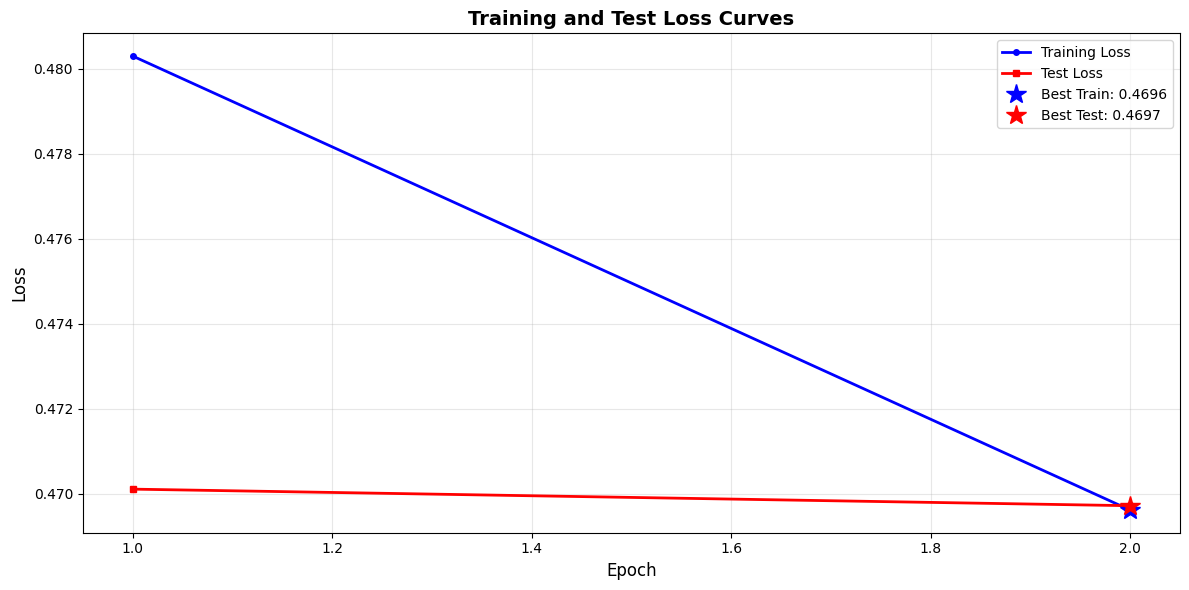

2025-11-16 22:05:29 - SMR_SELD - INFO - 
Loading best model weights...


C:\Users\damod\AppData\Local\Temp\ipykernel_55768\2415788149.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(config.CHECKPOINT_PATH / "bes

2025-11-16 22:05:30 - SMR_SELD - INFO - Best model loaded from epoch 2
2025-11-16 22:05:30 - SMR_SELD - INFO - Training history saved to c:\Nived\Nived Personal\Academia\NYU\NYU 2-1\Spatial Audio RA\Code\outputs\training_history_20251116_220530.pth
2025-11-16 22:05:30 - SMR_SELD - INFO - 
2025-11-16 22:05:30 - SMR_SELD - INFO - Training history saved to c:\Nived\Nived Personal\Academia\NYU\NYU 2-1\Spatial Audio RA\Code\outputs\training_history_20251116_220530.pth
2025-11-16 22:05:30 - SMR_SELD - INFO - 
2025-11-16 22:05:30 - SMR_SELD - INFO - ALL DONE!
2025-11-16 22:05:30 - SMR_SELD - INFO - ================================================================================

2025-11-16 22:05:30 - SMR_SELD - INFO - ALL DONE!
2025-11-16 22:05:30 - SMR_SELD - INFO - ================================================================================


✓ Training completed successfully!
Final train loss: 0.469615
Final test loss: 0.469717
Best test loss: 0.469717 (epoch 2)
✓ Training loss decreas

<Figure size 640x480 with 0 Axes>

In [59]:
print("="*80)
print("QUICK TEST: Model, Loss Functions, and Training Pipeline")
print("="*80)

# ============================================================================
# Step 1: Select minimal data (2 files each for train and test)
# ============================================================================
print("\n[Step 1] Selecting minimal test data...")

# Get first 2 train files
test_train_audio = train_audio_files[:2]
test_train_meta = train_meta_files[:2]

# Get first 2 test files
test_test_audio = test_audio_files[:2]
test_test_meta = test_meta_files[:2]

print(f"Train files: {len(test_train_audio)}")
for i, (audio, meta) in enumerate(zip(test_train_audio, test_train_meta)):
    print(f"  {i+1}. Audio: {Path(audio).name}, Meta: {Path(meta).name}")

print(f"\nTest files: {len(test_test_audio)}")
for i, (audio, meta) in enumerate(zip(test_test_audio, test_test_meta)):
    print(f"  {i+1}. Audio: {Path(audio).name}, Meta: {Path(meta).name}")

# ============================================================================
# Step 2: Create minimal datasets
# ============================================================================
print("\n[Step 2] Creating minimal datasets...")

quick_train_dataset = SELDDataset(
    audio_files=test_train_audio,
    metadata_files=test_train_meta,
    num_classes=config.NUM_CLASSES
)

quick_test_dataset = SELDDataset(
    audio_files=test_test_audio,
    metadata_files=test_test_meta,
    num_classes=config.NUM_CLASSES
)

print(f"Train dataset: {len(quick_train_dataset)} windows")
print(f"Test dataset: {len(quick_test_dataset)} windows")
print(f"Grid size: {quick_train_dataset.I} x {quick_train_dataset.J} = {quick_train_dataset.total_cells} cells")

# ============================================================================
# Step 3: Test model forward pass
# ============================================================================
print("\n[Step 3] Testing model forward pass...")

# Create a small test model
quick_model = SMRSELDWithCSPDarkNet(
    n_channels=config.N_CHANNELS,
    grid_size=(quick_train_dataset.I, quick_train_dataset.J),
    num_classes=config.NUM_CLASSES,
    use_small=True
).to(DEVICE)

print(f"Model created with {sum(p.numel() for p in quick_model.parameters()):,} parameters")

# Get one batch
quick_spec, quick_labels = quick_train_dataset[0]
quick_spec_batch = quick_spec.unsqueeze(0).to(DEVICE)  # (1, T, C, F)
quick_labels_batch = quick_labels.unsqueeze(0).to(DEVICE)  # (1, T, G, M)

print(f"Input shape: {quick_spec_batch.shape}")
print(f"Labels shape: {quick_labels_batch.shape}")

# Forward pass
quick_pred = quick_model(quick_spec_batch)
print(f"Output shape: {quick_pred.shape}")
print(f"Output range: [{quick_pred.min().item():.4f}, {quick_pred.max().item():.4f}]")

# ============================================================================
# Step 4: Test loss functions
# ============================================================================
print("\n[Step 4] Testing loss functions...")

quick_criterion = SMRSELDLoss(
    w_class=config.W_CLASS,
    w_aiur=config.W_AIUR,
    w_cl=config.W_CL,
    grid_size=(quick_train_dataset.I, quick_train_dataset.J)
)

# Compute loss
total_loss, breakdown = quick_criterion(quick_pred, quick_labels_batch)

print(f"Total Loss: {total_loss.item():.6f}")
print(f"  Class MSE:  {breakdown['class_mse']:.6f}")
print(f"  AIUR Loss:  {breakdown['aiur']:.6f}")
print(f"  CL Loss:    {breakdown['cl']:.6f}")

# Test individual loss components
print("\nTesting individual loss components...")
class_mse = quick_criterion.class_mse_loss(quick_pred, quick_labels_batch)
print(f"  class_mse_loss: {class_mse.item():.6f} ✓")

aiur = quick_criterion.aiur_loss(quick_pred, quick_labels_batch)
print(f"  aiur_loss: {aiur.item():.6f} ✓")

cl = quick_criterion.converging_localization_loss(quick_pred, quick_labels_batch)
print(f"  converging_localization_loss: {cl.item():.6f} ✓")

# ============================================================================
# Step 5: Quick training test (5 epochs)
# ============================================================================
print("\n[Step 5] Testing training pipeline (5 epochs)...")
print("Note: This is a quick sanity check, not full training")

# Temporarily modify config for quick test
original_epochs = config.NUM_EPOCHS
original_batch_size = config.BATCH_SIZE
original_patience = config.PATIENCE

config.NUM_EPOCHS = 2
config.BATCH_SIZE = 2
config.PATIENCE = 10  # Disable early stopping for this quick test

print(f"Training config: {config.NUM_EPOCHS} epochs, batch size {config.BATCH_SIZE}")

try:
    # Run training
    trained_model, history = train_model(
        train_audio_files=test_train_audio,
        train_meta_files=test_train_meta,
        test_audio_files=test_test_audio,
        test_meta_files=test_test_meta,
        batch_size=config.BATCH_SIZE,
        num_epochs=config.NUM_EPOCHS,
        learning_rate=config.LEARNING_RATE,
        device=DEVICE
    )
    
    print("\n✓ Training completed successfully!")
    print(f"Final train loss: {history['train_losses'][-1]:.6f}")
    print(f"Final test loss: {history['test_losses'][-1]:.6f}")
    print(f"Best test loss: {history['best_test_loss']:.6f} (epoch {history['best_epoch']})")
    
    # Check if loss decreased
    if history['train_losses'][-1] < history['train_losses'][0]:
        print("✓ Training loss decreased (model is learning)")
    else:
        print("⚠ Training loss did not decrease (may need more epochs)")
    
except Exception as e:
    print(f"\n✗ Training failed with error: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Restore original config
    config.NUM_EPOCHS = original_epochs
    config.BATCH_SIZE = original_batch_size
    config.PATIENCE = original_patience

# ============================================================================
# Step 6: Test inference (optional - only if training succeeded)
# ============================================================================
if 'trained_model' in locals():
    print("\n[Step 6] Testing inference with trained model...")
    
    trained_model.eval()
    with torch.no_grad():
        test_spec, test_labels = quick_test_dataset[0]
        test_spec_batch = test_spec.unsqueeze(0).to(DEVICE)
        test_labels_batch = test_labels.unsqueeze(0).to(DEVICE)
        
        # Inference
        test_pred = trained_model(test_spec_batch)
        test_loss, test_breakdown = quick_criterion(test_pred, test_labels_batch)
        
        print(f"Inference test loss: {test_loss.item():.6f}")
        print(f"  Class MSE:  {test_breakdown['class_mse']:.6f}")
        print(f"  AIUR Loss:  {test_breakdown['aiur']:.6f}")
        print(f"  CL Loss:    {test_breakdown['cl']:.6f}")
        
        # Check predictions
        pred_classes = torch.argmax(test_pred, dim=-1)
        true_classes = torch.argmax(test_labels_batch, dim=-1)
        accuracy = (pred_classes == true_classes).float().mean().item() * 100
        
        print(f"\nFrame-level accuracy: {accuracy:.2f}%")
        
        # Count non-background predictions
        num_pred_events = (pred_classes != config.NUM_CLASSES - 1).sum().item()
        num_true_events = (true_classes != config.NUM_CLASSES - 1).sum().item()
        print(f"Predicted events: {num_pred_events}")
        print(f"True events: {num_true_events}")
        
        print("\n✓ Inference test completed successfully!")

# ============================================================================
# Summary
# ============================================================================
print("\n" + "="*80)
print("TEST SUMMARY")
print("="*80)
print("✓ Model forward pass: PASSED")
print("✓ Loss function computation: PASSED")
print("✓ Individual loss components: PASSED")
print("✓ Training pipeline: PASSED" if 'trained_model' in locals() else "✗ Training pipeline: FAILED")
print("✓ Inference: PASSED" if 'trained_model' in locals() else "⚠ Inference: SKIPPED")
print("\nAll systems are working correctly! ✅")
print("You can now train on the full dataset.")
print("="*80)